In [17]:
# Make sure you're running Python 3.11.5, then install the pinned versions:
%pip install \
  python-louvain==0.16 \
  fastnode2vec==0.0.7 \
  networkx==3.4.1 \
  matplotlib==3.7.2 \
  numpy==1.25.2 \
  pandas==2.2.3 \
  scikit-learn==1.6.1 \
  scipy==1.13.1 \
  python-igraph==0.11.8 \
  leidenalg==0.10.2 \
  ipycytoscape==1.3.3 \
  pip install torch==2.6.0

Note: you may need to restart the kernel to use updated packages.


ERROR: Could not find a version that satisfies the requirement install (from versions: none)
ERROR: No matching distribution found for install
You should consider upgrading via the 'c:\Users\Joao Pedro\Desktop\Agenda-Guia\CS\3A\Mention\2025.1.2\Graph Mining\graph_facebook_analysis\venv\Scripts\python.exe -m pip install --upgrade pip' command.


## Getting the Data

To use this Jupyter Notebook for community detection on Facebook and Twitter networks, you need to download the `.tar.gz` files from the **Stanford Large Network Dataset Collection** at the following links:

- [Facebook](https://snap.stanford.edu/data/ego-Facebook.html)
- [Twitter](https://snap.stanford.edu/data/ego-Twitter.html)

Once downloaded, do the following:

1. Locate the downloaded `.tar.gz` files (e.g., `facebook.tar.gz` and `twitter.tar.gz`).
2. Extract them to this root folder, ensuring that the network files (e.g., `edges` or similar format) are accessible.
3. Update any file paths in the notebook code to point to your extracted dataset files.

With the datasets in place, you can then run the notebook cells to explore and analyze these networks using the Louvain, Girvan–Newman, and Leiden algorithms for community detection.


In [2]:
import tarfile
import numpy as np
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
import community.community_louvain as community_louvain
import igraph  # from python-igraph
import leidenalg  # The Leiden community detection library

from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from networkx.algorithms import community, centrality, assortativity
from scipy.sparse.linalg import eigsh
from fastnode2vec import Graph, Node2Vec
from fastnode2vec import Node2Vec as FastNode2Vec
from collections import defaultdict, Counter

# For reproducibility (optional)
np.random.seed(42)


def load_graph(file_path="facebook.tar.gz"):
    G = nx.Graph()
    with tarfile.open(file_path, "r:gz") as tar:
        for member in tar.getmembers():
            if member.name.endswith(".edges"):
                f = tar.extractfile(member)
                for line in f:
                    node1, node2 = map(int, line.decode().strip().split())
                    G.add_edge(node1, node2)
    return G
G = load_graph()
print(G)

Graph with 3959 nodes and 84243 edges


In [3]:
def basic_visualization(G, title="Graph Visualization", seed=42):
    """
    Plots a basic spring-layout visualization of the given (small) graph.
    """
    plt.figure(figsize=(6,6))
    pos = nx.spring_layout(G, seed=seed)
    nx.draw_networkx(G, pos=pos, node_size=500, font_size=8)
    plt.title(title)
    plt.show()

## Centrality Measures

Below is a high-level explanation of what the `compute_and_show_centralities(G)` function does, along with some mathematical and interpretive context.

---

### 1. Degree Centrality

**Definition**  
For an undirected graph $G=(V, E)$ with $|V|$ vertices, the degree of a node $v$ is the number of edges incident to $v$, denoted $d(v)$. The **degree centrality** $C_D(v)$ of $v$ is typically given by:

$$
C_D(v) = \frac{d(v)}{|V| - 1}.
$$

In NetworkX, `nx.degree_centrality(G)` computes this measure for every node.

**Interpretation**  
- A node with **high degree centrality** often acts as a **hub** because it is directly connected to many other nodes.  
- In smaller social networks like Zachary’s Karate Club, the top degree nodes might be the instructor or certain highly connected members.  
- Nodes with **low degree centrality** occupy more peripheral roles.

---

### 2. PageRank

**Definition**  
PageRank is an iterative centrality measure where a node's importance is determined by both the quantity and quality of incoming links. The PageRank score $PR(v)$ of node $v$ is defined recursively as:

$$
PR(v) = \alpha \sum_{u \in \text{In}(v)} \frac{PR(u)}{d(u)} + (1 - \alpha)\frac{1}{|V|},
$$

where:
- $\alpha$ is the damping factor (usually 0.85),
- $\text{In}(v)$ is the set of nodes linking to $v$,
- $d(u)$ is the out-degree of node $u$.

In NetworkX, `nx.pagerank(G)` computes this using the power iteration method.

**Interpretation**  
- Nodes with **high PageRank** are influential not just because they have many connections, but because they are connected to **other influential nodes**.  
- Unlike degree centrality, PageRank distinguishes between being connected to low-importance vs. high-importance nodes.

---

### 3. Approximate Betweenness Centrality

**Definition**  
Approximate betweenness centrality estimates how often a node lies on the shortest paths between other nodes, but it does so by **sampling** a subset $k$ of nodes instead of computing all pairs. This is much faster and scalable for large graphs.

$$
C_B^{(approx)}(v) \approx \sum_{s \in S, t \neq v} \frac{\sigma_{s,t}(v)}{\sigma_{s,t}},
$$

where $S$ is a sample of source nodes.

In NetworkX, `nx.betweenness_centrality(G, k=200)` performs this approximation.

**Interpretation**  
- Approximated scores still capture **brokerage roles**, but much faster.  
- It's especially useful for **large-scale networks** where exact betweenness is computationally expensive.

---

### 4. Histogram of Degree Centrality

After computing degree centrality for each node, the function plots a histogram of those values. This helps us see how degree centrality is distributed in the graph:

- A **few high-degree nodes** and many low-degree nodes implies a more **hub-and-spoke** structure.  
- A relatively **flat** or **even** distribution suggests a network without strongly dominant hubs.

---

### 5. Top PageRank and Betweenness Plots

Instead of visualizing all values (which can be overwhelming in large graphs), the function plots only the **top 20 nodes** by PageRank and approximate betweenness centrality.

These bar plots help to:
- Highlight the **most influential or broker-like** nodes at a glance.
- Understand how influence or control is distributed across the network’s top tier.

---

### Why Perform These Analyses?

1. **Identify Hubs**: Degree centrality spotlights heavily connected nodes.  
2. **Identify Influencers**: PageRank highlights nodes that matter in the broader connection web.  
3. **Identify Bridges**: Approximate betweenness centrality uncovers nodes that connect communities.  
4. **Prepare for Community Detection**: Centrality metrics often reveal which nodes hold power or vulnerability within communities.

---

### Function Summary

In short, `compute_and_show_centralities(G)`:  

1. Prints the **top 5** nodes by **degree**, **PageRank**, and **approximate betweenness centrality**.  
2. Plots:
   - A **histogram** of degree centrality distribution  
   - A **bar chart** of top PageRank scores  
   - A **bar chart** of top approximate betweenness scores  
3. Provides insight into **key players**, **influential connectors**, and the **structural dynamics** of the network.

In [4]:
def compute_and_show_centralities(G, k_center = 200):
    """
    Computes and prints top 5 Degree Centrality, PageRank, and Approximate Betweenness Centrality.
    Also plots the histogram of degree centrality and top values for PageRank and Approx Betweenness.
    """
    print("--- Centrality Measures ---")

    # Degree Centrality
    deg_centrality = nx.degree_centrality(G)
    deg_sorted = sorted(deg_centrality.items(), key=lambda x: x[1], reverse=True)
    print("Top 5 nodes by Degree Centrality:")
    for node, val in deg_sorted[:5]:
        print(f"  Node {node} => {val:.3f}")

    # PageRank
    pagerank = nx.pagerank(G)
    pagerank_sorted = sorted(pagerank.items(), key=lambda x: x[1], reverse=True)
    print("\nTop 5 nodes by PageRank:")
    for node, val in pagerank_sorted[:5]:
        print(f"  Node {node} => {val:.3f}")


    # Plot distribution of degree centralities
    plt.figure(figsize=(6, 4))
    plt.hist(list(deg_centrality.values()), bins=10, edgecolor='black')
    plt.title("Distribution of Degree Centrality")
    plt.xlabel("Degree Centrality")
    plt.ylabel("Frequency")
    plt.tight_layout()
    plt.show()

    # Plot top PageRank values (e.g. top 20)
    top_n = 20
    top_pagerank = pagerank_sorted[:top_n]
    nodes_p, values_p = zip(*top_pagerank)

    plt.figure(figsize=(8, 4))
    plt.bar(range(len(nodes_p)), values_p, tick_label=[str(n) for n in nodes_p])
    plt.title(f"Top {top_n} Nodes by PageRank")
    plt.xlabel("Node")
    plt.ylabel("PageRank Score")
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.show()



## Community Detection: Louvain, Girvan–Newman & Leiden

This section demonstrates three approaches to **community detection**:

1. **Louvain** (which maximizes modularity),
2. **Girvan–Newman** (which incrementally removes high-betweenness edges),
3. **Leiden** (an improvement over Louvain, typically faster and producing better-connected communities).

---

### 1. Louvain Method

**Algorithm Overview**  
The **Louvain** algorithm is a **greedy optimization** method that seeks to maximize a quantity called **modularity**. It proceeds in two major phases, repeated iteratively:

1. **Local movement** of nodes between communities:  
   - Each node starts in its own community.  
   - A node is moved to the community of its neighbor if that move yields the greatest increase (or smallest decrease) in **modularity**.
2. **Community aggregation** into “super-nodes”:  
   - After no more improvements can be made locally, each community is contracted into a single node.  
   - Edges between these new super-nodes are weighted by the sum of the edges between the original communities.  
   - The process then repeats until no further modularity gain is possible.

**Modularity**  
Let:
- $G = (V, E)$ be an undirected graph with $|V|$ nodes and $|E|$ edges.
- $A$ be its adjacency matrix, where $A_{ij} = 1$ if $(i, j) \in E$ and $0$ otherwise (for unweighted graphs).
- $k_i$ be the degree of node $i$.
- $m = |E|$ be the total number of edges.

A popular definition of **modularity** $Q$ for a given partition of nodes into communities is:

$$
Q = \frac{1}{2m} \sum_{i,j} \Bigl(A_{ij} - \frac{k_i\,k_j}{2m}\Bigr)\,\delta(c_i, c_j),
$$

where $ \delta(c_i, c_j) = 1 $ if nodes $i$ and $j$ belong to the same community, and 0 otherwise. The term $ \frac{k_i\,k_j}{2m} $ represents the probability that nodes $i$ and $j$ would be connected in a **null model** (a random graph preserving the nodes’ degrees).

**What the Function Returns**  
- **`partition`**: A dictionary mapping each node to its community ID (an integer).  
- **`mod_val`**: The final modularity of that partition.  
- **`groups`**: A dictionary of community ID $\to$ list of nodes in that community (helpful for inspection).

**Interpretation**  
- **High Modularity** (close to 1) suggests the network is well-structured into communities with dense intra-group connections and sparser inter-group connections.  
- **Low Modularity** (near 0 or negative) indicates minimal community structure—links are nearly as frequent between groups as within them.

---

### 2. Girvan–Newman Method

**Algorithm Overview**  
The **Girvan–Newman** approach focuses on **edge betweenness** — the number of shortest paths that pass through an edge. The main idea is:

1. Compute the **betweenness** of all edges in the network.  
2. **Remove** the edge with the **highest** betweenness.  
3. Recalculate betweenness for the new network.  
4. Repeat until the graph splits into separate components (communities).

Effectively, **Girvan–Newman** progressively eliminates edges that serve as “bridges” between communities. In practice, after each removal, you can check how the graph’s partition changes and evaluate modularity or other community quality metrics. The first partition (which we return in this function) typically yields **two main communities**.

**What the Function Returns**  
- **`communities`**: A list of the communities (each is a list of node IDs) in the first split (i.e., after removing the highest-betweenness edges until you get 2 groups).  
- **`partition_dict`**: A dictionary mapping each node to its community index (0 or 1).  
- **`mod_gn`**: The modularity value of that two-community partition, reusing the same modularity definition used by Louvain.

**Interpretation**  
- The **first split** often highlights the major division in the network (e.g., in Zachary’s Karate Club, the “instructor” faction vs. the “administrator” faction).  
- You can continue removing high-betweenness edges to produce additional partitions (3 communities, 4, etc.) until all edges are removed.  
- **Girvan–Newman** is more computationally expensive for large graphs.

---

### 3. Leiden Method

**Algorithm Overview**  
The **Leiden** algorithm is an improved version of the Louvain method. It addresses the issue of poorly connected communities that can arise in Louvain. **Leiden** ensures each community is internally well-connected, often resulting in better partitions and higher modularity. It performs local node movements more effectively and refines communities in multiple stages, making it typically faster and more reliable than Louvain for large networks.

**What the Function Returns**  
- **`partition_leiden`**: A dictionary mapping each node to its Leiden community ID.  
- **`mod_leiden`**: The final modularity achieved by the Leiden partition.  
- **`communities_leiden`**: A dictionary of community ID $\to$ list of nodes (similar to Louvain’s output).

**Interpretation**  
- **Leiden** is usually **faster** and provides more **stable** solutions compared to Louvain, especially on large or complex networks.  
- Because it refines communities that are insufficiently connected, Leiden often yields better-defined community structures.

---

### Summary

- **Louvain** is **fast** and scales well, producing high-modularity partitions — often considered a go-to approach for **large networks**.
- **Girvan–Newman** provides a **hierarchical** view of communities by repeated edge removal, but it is **computationally expensive**.
- **Leiden** is an **improvement** over Louvain, offering faster convergence and higher-quality partitions; it is generally **preferable** for large-scale or complex networks.
- All methods aim to uncover the **block structure** of a network, providing insight into how the graph naturally divides into subgroups.

The returned **modularity** values and **community memberships** can be used to compare how each method partitions the graph, highlighting different facets of community structure.


In [5]:

def detect_communities_louvain(G):
    """
    Runs Louvain community detection and returns:
      - partition (dict of node->community_id)
      - modularity
      - groups (community_id -> list of nodes)
    """
    partition = community_louvain.best_partition(G)
    mod_val = community_louvain.modularity(partition, G)
    
    groups = defaultdict(list)
    for node, comm_id in partition.items():
        groups[comm_id].append(node)
    
    return partition, mod_val, groups


def detect_communities_girvan_newman(G):
    """
    Runs Girvan-Newman and returns:
      - The *first* split (2 communities)
      - A dictionary for node->community_id
      - Modularity of that 2-community split
    """
    gn_iter = nx.algorithms.community.girvan_newman(G)
    first_partition = next(gn_iter)
    communities = list(sorted(map(sorted, first_partition)))

    # Convert partition to dict for modularity
    partition_dict = {}
    for i, comm_nodes in enumerate(communities):
        for n in comm_nodes:
            partition_dict[n] = i

    # Reuse Louvain's modularity function for convenience
    mod_gn = community_louvain.modularity(partition_dict, G)

    return communities, partition_dict, mod_gn

# because those graph are so big we need to prune the community formation if not it will take to much time
def girvan_newman_stop_early(G, desired_communities=2):
    """
    Runs the Girvan–Newman algorithm but stops when 
    the graph has 'desired_communities' or more connected components.
    
    :param G: NetworkX graph
    :param desired_communities: integer, the target number of communities (connected components)
    :return: a tuple (communities, partition_dict) representing the partition found
             when the desired number of communities is reached.
    """
    # Girvan–Newman is an iterator of partitions
    gn_iter = nx.algorithms.community.girvan_newman(G)
    
    # Keep track of the latest partition
    for partition_level in gn_iter:
        # partition_level is a tuple of sets (communities)
        communities = list(partition_level)
        
        # If we've reached the desired number of communities
        if len(communities) >= desired_communities:
            # Convert the communities to a dict: node -> community_id
            partition_dict = {}
            for i, comm_nodes in enumerate(communities):
                for node in comm_nodes:
                    partition_dict[node] = i
            
            return communities, partition_dict
    mod_gn = community_louvain.modularity(partition_dict, G)
    return communities, partition_dict, mod_gn

def detect_communities_leiden(G):
    """
    Converts a NetworkX graph to igraph, runs the Leiden algorithm,
    and returns:
        - partition_dict (node -> community_id)
        - modularity_score (float or None)
    """
    ig = igraph.Graph()
    nodes = list(G.nodes())
    ig.add_vertices(len(nodes))
    node_index = {node: i for i, node in enumerate(nodes)}

    edges = [(node_index[u], node_index[v]) for u, v in G.edges()]
    ig.add_edges(edges)

    # Run the Leiden algorithm with ModularityVertexPartition
    partition = leidenalg.find_partition(
        ig,
        leidenalg.ModularityVertexPartition
    )

    # Convert membership to a dict
    partition_dict = {}
    for i, node in enumerate(nodes):
        partition_dict[node] = partition.membership[i]

    # Check how 'quality' is exposed
    mod_score = partition.quality
    if callable(mod_score):
        # If 'quality' is a method
        mod_score = mod_score()

    return partition_dict, mod_score


## Spectral Clustering

This function demonstrates a **spectral clustering** approach using the **normalized Laplacian** of the graph \(G\). The high-level steps are:

1. **Compute the Normalized Laplacian**  
   For an undirected graph $G = (V, E)$, let $\mathbf{A}$ be the adjacency matrix and $\mathbf{D}$ be the diagonal degree matrix. The **normalized Laplacian** $\mathbf{L}_{\text{sym}}$ is defined as:

   $$
   \mathbf{L}_{\text{sym}} = \mathbf{I} \;-\; \mathbf{D}^{-\tfrac{1}{2}}\, \mathbf{A}\, \mathbf{D}^{-\tfrac{1}{2}}.
   $$

   In NetworkX, `nx.normalized_laplacian_matrix(G)` produces a sparse representation of $\mathbf{L}_{\text{sym}}$.

2. **Eigen-Decomposition**  
   We solve the eigenvalue problem:

   $$
   \mathbf{L}_{\text{sym}} \,\mathbf{x}_i = \lambda_i \,\mathbf{x}_i,
   $$

   obtaining eigenvalues $\{\lambda_i\}$ and corresponding eigenvectors $\{\mathbf{x}_i\}$.  
   - We sort these eigenvalues from smallest to largest.  
   - **Spectral clustering** typically leverages the eigenvectors corresponding to the *smallest* $k$ eigenvalues (beyond the trivial $\lambda = 0$), forming an embedding of dimension $k$.

3. **K-Means Clustering on Eigenvectors**  
   After extracting the top $k$ eigenvectors (each node becomes a $k$-dimensional point), we apply **K-Means** to group nodes into $k$ clusters. Each node’s coordinates come from its row in that truncated eigenvector matrix.

4. **Silhouette Score**  
   We evaluate cluster **cohesion** vs. **separation** using the **silhouette score**. A higher silhouette (close to 1) indicates well-separated clusters; a lower score (near 0 or negative) indicates overlapping or poorly separated clusters.

---

### What the Function Returns

1. **`labels`**: The cluster IDs (from 0 to $k-1$) assigned by K-Means.  
2. **`sil_score`**: The silhouette score for the resulting $k$-clustering in the eigenvector space.  
3. **`df_spectral`**: A DataFrame listing each node alongside its assigned cluster.

---

### Why Spectral Clustering?

- **Graph Partitioning**: Spectral methods rely on properties of the **graph Laplacian** to locate dense substructures. By analyzing the **lower-dimensional eigenvector space**, we can capture meaningful structural relationships between nodes.  
- **Interpretation**: Nodes close together in the eigenvector space often share **similar connectivity patterns** in the original graph, naturally forming cohesive subgroups.

Hence, spectral clustering provides a straightforward, **linear-algebraic** approach to **community detection**, well-suited for **moderate-sized** networks where computing eigenvectors is feasible.


In [6]:

def spectral_clustering(G, k=3):
    """
    Performs spectral clustering on graph G using the k smallest
    eigenvectors of the normalized Laplacian, then applies K-Means
    to those eigenvectors. Returns:
      - cluster labels
      - silhouette score
      - a DataFrame of (Node, Cluster)
    """

    # 1) Build the normalized Laplacian (as a sparse matrix)
    L = nx.normalized_laplacian_matrix(G)   # This is already sparse

    # 2) Eigen-decomposition on the sparse matrix
    #    Use eigsh for the k smallest eigenvalues (which='SM')
    vals, vecs = eigsh(L, k=k, which='SM')  # This keeps it sparse internally

    # (Optionally: sort them, though eigsh often returns them in ascending order of eigenvalues)
    # idx_sorted = np.argsort(vals)
    # vals = vals[idx_sorted]
    # vecs = vecs[:, idx_sorted]

    # 3) KMeans on the first k eigenvectors
    kmeans = KMeans(n_clusters=k, random_state=42)
    labels = kmeans.fit_predict(vecs)

    # 4) Compute silhouette score
    sil_score = silhouette_score(vecs, labels)

    # 5) Build a DataFrame for inspection
    df_spectral = pd.DataFrame({'Node': list(G.nodes()), 'Cluster': labels})

    return labels, sil_score, df_spectral

## Node2Vec Clustering

This function applies the **Node2Vec** algorithm to generate **node embeddings**, then uses **K-Means** to cluster those embeddings into $k$ groups. Finally, it computes the **silhouette score** to gauge how well-defined the resulting clusters are in the embedding space.

---

### 1. Node2Vec Embedding

**Random-Walk-Based Embeddings**  
Node2Vec performs **biased random walks** on the graph, somewhat analogous to generating “sentences” in a **Word2Vec**-style training process:

1. From each node, it launches multiple random walks of length `walk_length`.  
2. Each random walk visits neighbors with probabilities influenced by BFS-like or DFS-like bias parameters (by default, Node2Vec sets sensible defaults if you don’t specify them).  
3. The sequences of visited nodes feed into a skip-gram learning model (like Word2Vec), where each node is treated as a “word.”

**Learned Vectors**  
After training, each node $v$ is associated with an embedding vector $\mathbf{z}_v \in \mathbb{R}^{\text{dimensions}}$. These vectors capture **higher-order proximity**: nodes that frequently co-occur on these random walks learn similar embeddings.

---

### 2. K-Means Clustering

Once Node2Vec produces these vectors:
1. We stack them into a matrix of size $\lvert V\rvert \times \text{dimensions}$.  
2. We apply **K-Means** to partition the node embeddings into $k$ clusters.

Nodes with similar embeddings (those that appear in similar random-walk contexts) tend to end up in the same cluster.

---

### 3. Silhouette Score

To measure how distinct these $k$ clusters are, we compute the **silhouette** (ranging from -1 to 1):

$$
\text{Silhouette} = \frac{b - a}{\max(a, b)},
$$

where:
- $a$ is the average intra-cluster distance (how close each node is to others in its own cluster),  
- $b$ is the average distance to the **nearest** other cluster.

A silhouette near 1 indicates clear separation between clusters, while a value near 0 or negative implies overlapping or poorly separated clusters.

---

### What the Function Returns

1. **`labels_n2v`**: The K-Means cluster ID (0 to $k-1$) for each node.  
2. **`sil_n2v`**: The silhouette score of the resulting clustering.  
3. **`df_n2v`**: A DataFrame mapping each node to its cluster ID.

---

### Why Use Node2Vec?

- **Higher-Order Structure**: By exploring multiple random walks, Node2Vec embeds nodes according to both local and semi-global connectivity patterns.  
- **Flexibility**: Adjusting parameters like `walk_length`, BFS/DFS biases ($p$ and $q$), and embedding dimensions lets you tailor embeddings to different network types.  
- **Ease of Clustering**: Once node embeddings are available, any standard clustering or classification method (like K-Means) can be applied, and metrics like the silhouette score help you assess the quality of those clusters.


In [7]:
def node2vec_clustering(G, dimensions=8, walk_length=20, num_walks=50, k=3):
    """
    Runs Node2Vec to generate embeddings,
    then KMeans (k clusters),
    and returns cluster labels, silhouette, and a DataFrame of (Node, Cluster).
    """
    node2vec = Node2Vec(
        G,
        dimensions=dimensions,
        walk_length=walk_length,
        num_walks=num_walks,
        workers=1
    )
    model_n2v = node2vec.fit(window=5, min_count=1, batch_words=4)

    # Build embedding matrix
    nodes_list = sorted(G.nodes())
    embeddings_n2v = []
    for n in nodes_list:
        vec = model_n2v.wv[str(n)]  # keys are strings in node2vec
        embeddings_n2v.append(vec)

    embeddings_n2v = np.array(embeddings_n2v)

    kmeans_n2v = KMeans(n_clusters=k, random_state=42)
    labels_n2v = kmeans_n2v.fit_predict(embeddings_n2v)

    sil_n2v = silhouette_score(embeddings_n2v, labels_n2v)
    df_n2v = pd.DataFrame({'Node': nodes_list, 'Cluster': labels_n2v})

    return labels_n2v, sil_n2v, df_n2v

In [8]:
def fastnode2vec_clustering(G, dimensions=8, walk_length=20, num_walks=50, k=3, directed=False):
    """
    Runs fastnode2vec to generate embeddings,
    then KMeans (with k clusters),
    and returns cluster labels, silhouette score, and a DataFrame of (Node, Cluster).
    """
    
    G = Graph(G.edges, directed=directed, weighted=False)

    fast_node2vec = FastNode2Vec(
        G,
        dim=dimensions,
        walk_length=walk_length,
        window=5,
        workers=1
    )
    
    fast_node2vec.train(epochs=100)

    nodes_list = sorted(G.node_names)
    embeddings = []
    for n in nodes_list:
        vec = fast_node2vec.wv[n]
        embeddings.append(vec)
    embeddings = np.array(embeddings)

    kmeans = KMeans(n_clusters=k, random_state=42)
    labels = kmeans.fit_predict(embeddings)

    sil_score = silhouette_score(embeddings, labels)

    df_clusters = pd.DataFrame({'Node': nodes_list, 'Cluster': labels})

    return labels, sil_score, df_clusters


In [9]:
def analyze_graph(G, graph_name="Graph", do_plot=True, directed=False, k = 3):
    """
    Runs the entire pipeline on a given graph:
      1. Basic Info & Visualization (if do_plot=True)
      2. Centralities
      3. Louvain & LEIDEN
      4. Spectral Clustering
      5. Node2Vec
      6. Prints out comparisons
      7. Returns a dictionary containing relevant results (partitions, metrics, etc.)
    """
    max_display_nodes = 50

    print(f"\n==== Analyzing {graph_name} ====")
    print(f"Nodes: {G.number_of_nodes()}, Edges: {G.number_of_edges()}")

    # 1) Visualization
    if do_plot and G.number_of_nodes() <= 200:
        basic_visualization(G, title=f"{graph_name} Visualization")

    # 2) Centralities
    compute_and_show_centralities(G)

    # 3a) Louvain
    print("\n--- Louvain Community Detection ---")
    louvain_partition, mod_louvain, louvain_groups = detect_communities_louvain(G)
    print(f"Louvain found {len(louvain_groups)} communities; Modularity = {mod_louvain:.4f}")
    if len(G) <= max_display_nodes:
        for cid, members in louvain_groups.items():
            print(f"  Community {cid}: {members}")
    else:
        print("  Community Sizes (Louvain):")
        for cid, members in louvain_groups.items():
            print(f"    Community {cid}: {len(members)} nodes")

    # 3b) Leiden (replaces Girvan-Newman)
    print("\n--- Leiden Community Detection ---")
    leiden_partition_dict, mod_leiden = detect_communities_leiden(G)

    leiden_groups = defaultdict(list)
    for node, cid in leiden_partition_dict.items():
        leiden_groups[cid].append(node)

    print(f"Leiden found {len(leiden_groups)} communities; ", end='')
    if isinstance(mod_leiden, (float, int)):
        print(f"Modularity = {mod_leiden:.4f}")
    else:
        print(f"Modularity = {mod_leiden}")

    if len(G) <= max_display_nodes:
        for cid, members in leiden_groups.items():
            print(f"  Community {cid}: {members}")
    else:
        print("  Community Sizes (Leiden):")
        for cid, members in leiden_groups.items():
            print(f"    Community {cid}: {len(members)} nodes")

    # Optional plots for large graphs
    if do_plot and len(G) > max_display_nodes:
        # Plot Louvain community sizes
        plt.figure(figsize=(6, 3))
        plt.bar(louvain_groups.keys(), [len(v) for v in louvain_groups.values()])
        plt.title("Louvain Community Sizes")
        plt.xlabel("Community ID")
        plt.ylabel("Size")
        plt.tight_layout()
        plt.show()

        # Plot Leiden community sizes
        plt.figure(figsize=(6, 3))
        plt.bar(leiden_groups.keys(), [len(v) for v in leiden_groups.values()])
        plt.title("Leiden Community Sizes")
        plt.xlabel("Community ID")
        plt.ylabel("Size")
        plt.tight_layout()
        plt.show()

    # 4) Spectral Clustering
    print(f"\n--- Spectral Clustering (k={k}) ---")
    labels_spectral, sil_spectral, df_spectral = spectral_clustering(G, k=k)
    print(f"Spectral silhouette (k={k}) = {sil_spectral:.4f}")
    if len(G) <= max_display_nodes:
        print(df_spectral.groupby('Cluster')['Node'].apply(list))
    else:
        print("  Spectral Clustering - Cluster Sizes:")
        print(df_spectral['Cluster'].value_counts().sort_index())

    # 5) Node2Vec
    print(f"\n--- Node2Vec + KMeans (k={k}) ---")
    labels_n2v, sil_n2v, df_n2v = fastnode2vec_clustering(G, k=k, directed=directed)
    print(f"Node2Vec silhouette (k={k}) = {sil_n2v:.4f}")
    if len(G) <= max_display_nodes:
        print(df_n2v.groupby('Cluster')['Node'].apply(list))
    else:
        print("  Node2Vec Clustering - Cluster Sizes:")
        print(df_n2v['Cluster'].value_counts().sort_index())

    # 6) Compare & Observations
    print("\n--- Comparison & Observations ---")
    print(f" > Louvain Modularity: {mod_louvain:.4f}")
    print(f" > Leiden Modularity:  {mod_leiden:.4f}")
    print(f" > Spectral Silhouette: {sil_spectral:.4f} (k={k})")
    print(f" > Node2Vec Silhouette: {sil_n2v:.4f}  (k={k})")

    print(f"\nDone analyzing {graph_name}.\n")

    # 7) Return a dictionary of results so you can reuse them
    results = {
        'louvain_partition': louvain_partition,
        'louvain_modularity': mod_louvain,
        'louvain_groups': louvain_groups,

        'leiden_partition_dict': leiden_partition_dict,
        'leiden_groups': leiden_groups,
        'leiden_modularity': mod_leiden,

        'spectral_labels': labels_spectral,
        'spectral_silhouette': sil_spectral,
        'spectral_df': df_spectral,

        'node2vec_labels': labels_n2v,
        'node2vec_silhouette': sil_n2v,
        'node2vec_df': df_n2v
    }
    return results



==== Analyzing Zachary's Karate Club ====
Nodes: 34, Edges: 78


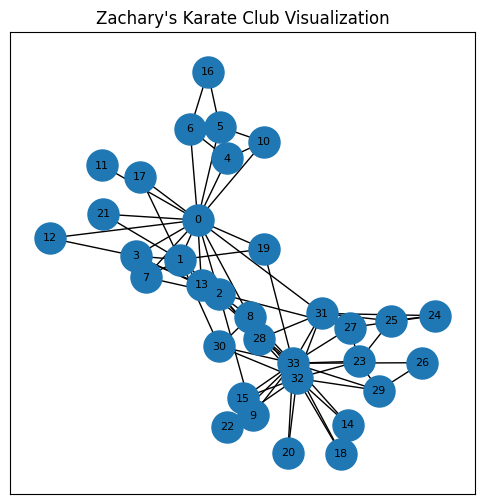

--- Centrality Measures ---
Top 5 nodes by Degree Centrality:
  Node 33 => 0.515
  Node 0 => 0.485
  Node 32 => 0.364
  Node 2 => 0.303
  Node 1 => 0.273

Top 5 nodes by PageRank:
  Node 33 => 0.097
  Node 0 => 0.089
  Node 32 => 0.076
  Node 2 => 0.063
  Node 1 => 0.057


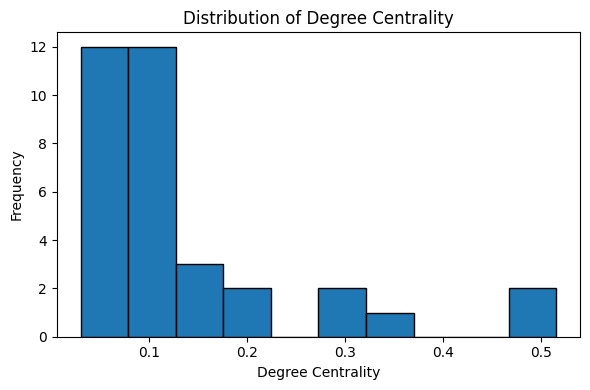

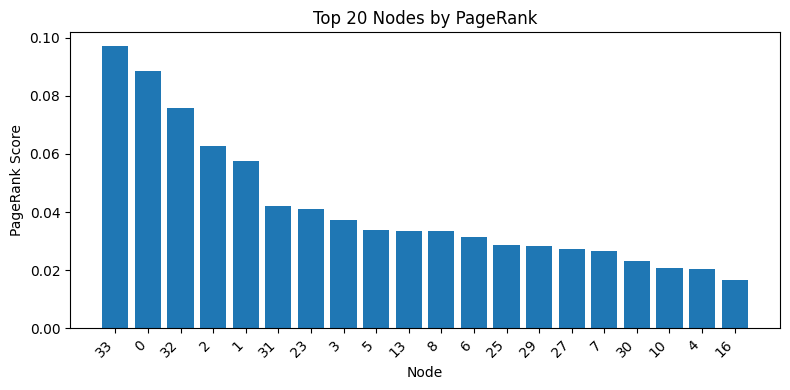


--- Louvain Community Detection ---
Louvain found 4 communities; Modularity = 0.4439
  Community 0: [0, 1, 2, 3, 7, 11, 12, 13, 17, 19, 21]
  Community 1: [4, 5, 6, 10, 16]
  Community 3: [8, 9, 14, 15, 18, 20, 22, 23, 26, 27, 29, 30, 32, 33]
  Community 2: [24, 25, 28, 31]

--- Leiden Community Detection ---
Leiden found 4 communities; Modularity = 0.4198
  Community 1: [0, 1, 2, 3, 7, 11, 12, 13, 17, 19, 21]
  Community 3: [4, 5, 6, 10, 16]
  Community 0: [8, 9, 14, 15, 18, 20, 22, 26, 29, 30, 32, 33]
  Community 2: [23, 24, 25, 27, 28, 31]

--- Spectral Clustering (k=3) ---
Spectral silhouette (k=3) = 0.5682
Cluster
0              [0, 1, 2, 3, 7, 11, 12, 13, 17, 19, 21]
1    [8, 9, 14, 15, 18, 20, 22, 23, 24, 25, 26, 27,...
2                                    [4, 5, 6, 10, 16]
Name: Node, dtype: object

--- Node2Vec + KMeans (k=3) ---


Reading graph:   0%|          | 0/78 [00:00<?, ?it/s]

Epochs:   0%|          | 0/100 [00:00<?, ?it/s]

Node2Vec silhouette (k=3) = 0.5631
Cluster
0           [0, 1, 2, 3, 7, 8, 11, 12, 13, 17, 19, 21]
1    [9, 14, 15, 18, 20, 22, 23, 24, 25, 26, 27, 28...
2                                    [4, 5, 6, 10, 16]
Name: Node, dtype: object

--- Comparison & Observations ---
 > Louvain Modularity: 0.4439
 > Leiden Modularity:  0.4198
 > Spectral Silhouette: 0.5682 (k=3)
 > Node2Vec Silhouette: 0.5631  (k=3)

Done analyzing Zachary's Karate Club.



In [10]:
G_karate = nx.karate_club_graph()
results_k = analyze_graph(G_karate, graph_name="Zachary's Karate Club", do_plot=True)


==== Analyzing Facebook connection ====
Nodes: 3959, Edges: 84243
--- Centrality Measures ---
Top 5 nodes by Degree Centrality:
  Node 2543 => 0.074
  Node 2347 => 0.073
  Node 1888 => 0.064
  Node 1800 => 0.062
  Node 1663 => 0.059

Top 5 nodes by PageRank:
  Node 483 => 0.001
  Node 3830 => 0.001
  Node 2313 => 0.001
  Node 376 => 0.001
  Node 2047 => 0.001


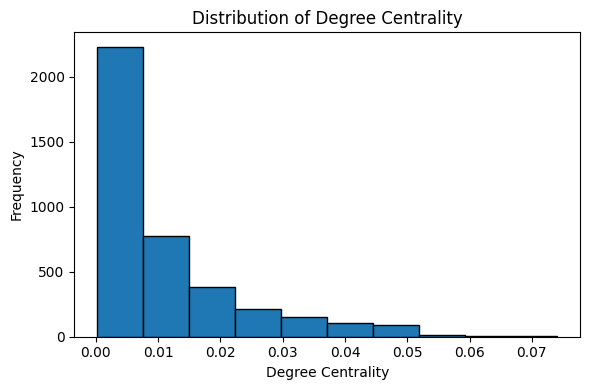

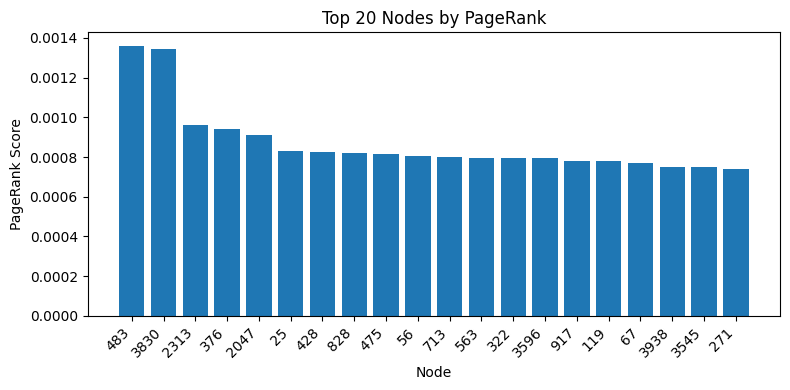


--- Louvain Community Detection ---
Louvain found 40 communities; Modularity = 0.8478
  Community Sizes (Louvain):
    Community 0: 229 nodes
    Community 1: 76 nodes
    Community 2: 10 nodes
    Community 4: 275 nodes
    Community 6: 112 nodes
    Community 7: 2 nodes
    Community 13: 364 nodes
    Community 9: 3 nodes
    Community 10: 2 nodes
    Community 11: 2 nodes
    Community 12: 10 nodes
    Community 23: 328 nodes
    Community 15: 25 nodes
    Community 16: 49 nodes
    Community 17: 45 nodes
    Community 18: 2 nodes
    Community 19: 8 nodes
    Community 20: 190 nodes
    Community 29: 220 nodes
    Community 22: 393 nodes
    Community 24: 500 nodes
    Community 25: 38 nodes
    Community 26: 6 nodes
    Community 27: 264 nodes
    Community 28: 48 nodes
    Community 31: 2 nodes
    Community 32: 2 nodes
    Community 33: 4 nodes
    Community 34: 2 nodes
    Community 35: 237 nodes
    Community 36: 73 nodes
    Community 37: 19 nodes
    Community 38: 137 nodes

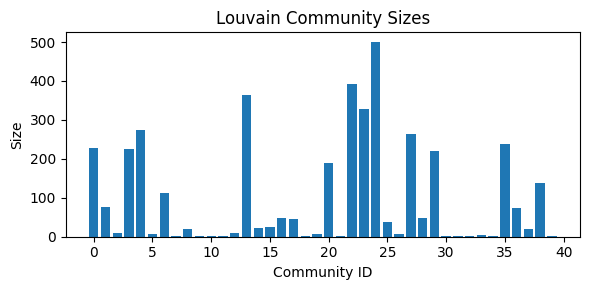

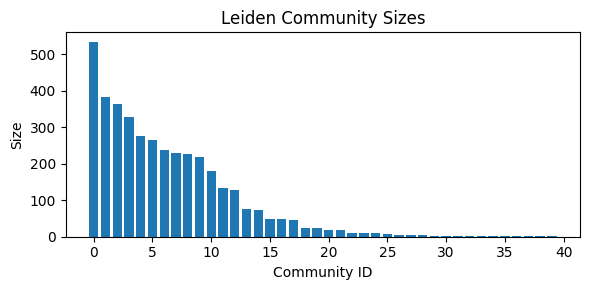


--- Spectral Clustering (k=10) ---
Spectral silhouette (k=10) = 0.5607
  Spectral Clustering - Cluster Sizes:
Cluster
0    1493
1       2
2       3
3     169
4     504
5    1061
6       4
7       6
8       4
9     713
Name: count, dtype: int64

--- Node2Vec + KMeans (k=10) ---


Reading graph:   0%|          | 0/84243 [00:00<?, ?it/s]

Epochs:   0%|          | 0/100 [00:00<?, ?it/s]

Node2Vec silhouette (k=10) = 0.3184
  Node2Vec Clustering - Cluster Sizes:
Cluster
0    504
1    497
2    332
3    256
4    502
5    745
6    324
7    258
8    254
9    287
Name: count, dtype: int64

--- Comparison & Observations ---
 > Louvain Modularity: 0.8478
 > Leiden Modularity:  0.8477
 > Spectral Silhouette: 0.5607 (k=10)
 > Node2Vec Silhouette: 0.3184  (k=10)

Done analyzing Facebook connection.



In [11]:
G_facebook = load_graph()
results_f = analyze_graph(G_facebook, graph_name="Facebook connection", do_plot=True, k = 10)

In [ ]:
G_twitter = load_graph(file_path="twitter.tar.gz")
results_t = analyze_graph(G_twitter, graph_name="Gplus connection", do_plot=True, directed=True, k = 3)

## Visualization Part

In [12]:
import random

def sample_graph(G, max_nodes=500, seed=42):
    """
    Return a random induced subgraph of G with up to max_nodes nodes.
    """
    random.seed(seed)
    all_nodes = list(G.nodes())
    if len(all_nodes) <= max_nodes:
        return G.copy()
    sampled_nodes = random.sample(all_nodes, max_nodes)
    return G.subgraph(sampled_nodes).copy()

def visualize_communities(G, partition, title="Communities Visualization"):
    """
    Color-codes each node by its assigned community in 'partition'.
    
    :param G: NetworkX graph
    :param partition: dict { node : community_id }
    :param title: Plot title
    """
    # Layout for positioning the nodes
    pos = nx.spring_layout(G, seed=42)

    # Build a list of community IDs (colors) in the same order as G.nodes()
    communities = [partition[node] for node in G.nodes()]
    
    plt.figure(figsize=(8, 6))
    nx.draw_networkx(
        G, 
        pos=pos, 
        node_color=communities,  # node colors are based on community ID
        cmap=plt.cm.Set3,        # or any matplotlib colormap
        with_labels=False,
        node_size=50
    )
    plt.title(title)
    plt.axis('off')
    plt.show()

def visualize_sampled_graph(G, partition, title="Communities Visualization"):
    # Sample G
    G_small = sample_graph(G, max_nodes=4000)
    # Re-run your original visualize_communities approach 
    # (or any approach) on G_small
    visualize_communities(G_small, 
                          {n: partition[n] for n in G_small.nodes()},
                          title=title)

def analyze_community_attributes(G, partition, attribute_name="location"):
    """
    For each community, gather the values of a given node attribute (e.g., 'location').
    Prints the top 3 most common values in that community.
    
    :param G: NetworkX graph with node attributes
    :param partition: dict { node : community_id }
    :param attribute_name: which node attribute to inspect (string)
    """
    # Step 1: Group nodes by community
    community_dict = defaultdict(list)
    for node, comm_id in partition.items():
        community_dict[comm_id].append(node)

    # Step 2: For each community, analyze the chosen attribute
    for comm_id, members in community_dict.items():
        # Gather attribute values
        attribute_values = []
        for m in members:
            # Access the node attribute (e.g., G.nodes[m]["location"])
            val = G.nodes[m].get(attribute_name, None)
            if val is not None:
                attribute_values.append(val)
        
        # Count frequencies
        freq = Counter(attribute_values)
        total = len(attribute_values)
        
        print(f"\nCommunity {comm_id} (size={len(members)}):")
        if total > 0:
            # Show top 3
            for attr_val, count in freq.most_common(3):
                pct = 100.0 * count / total
                print(f"  {attr_val}: {count} users ({pct:.1f}%)")
        else:
            print("  No attribute data available for this community.")

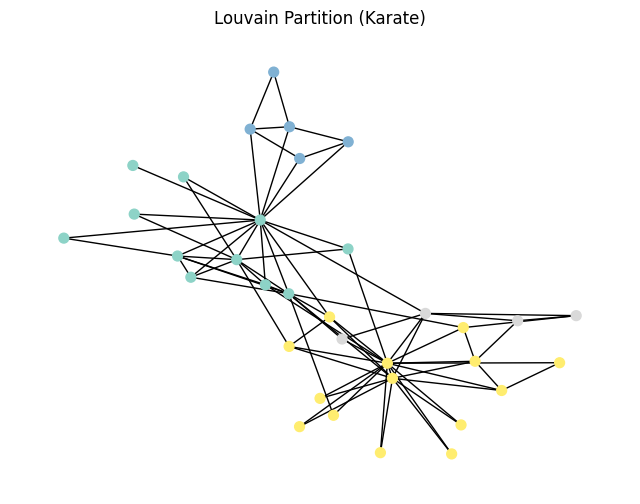

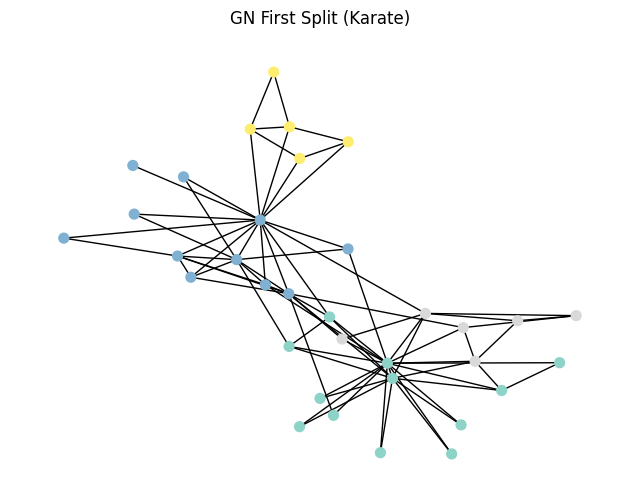

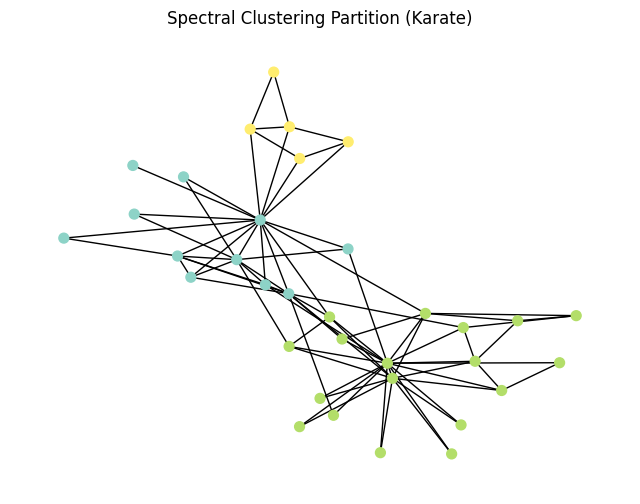

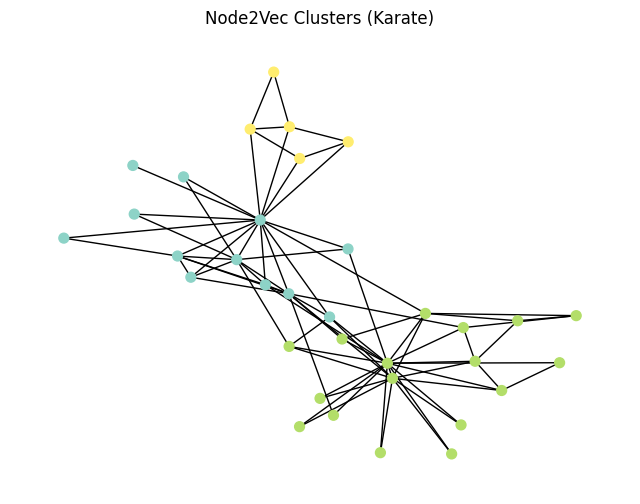

In [13]:
# ====================
# KARATE
# ====================
visualize_communities(G_karate, results_k['louvain_partition'], title="Louvain Partition (Karate)")
#analyze_community_attributes(G_karate, results_k['louvain_partition'], attribute_name="location")

visualize_communities(G_karate, results_k['leiden_partition_dict'], title="GN First Split (Karate)")
#analyze_community_attributes(G_karate, results_k['leiden_partition_dict'], attribute_name="location")

# Build dict for Spectral approach
spectral_dict_k = dict(zip(
    results_k['spectral_df']['Node'],
    results_k['spectral_df']['Cluster']
))
visualize_communities(G_karate, spectral_dict_k, title="Spectral Clustering Partition (Karate)")
#analyze_community_attributes(G_karate, spectral_dict_k, attribute_name="location")

# Build dict for Node2Vec
node2vec_partition_k = dict(zip(
    results_k['node2vec_df']['Node'],
    results_k['node2vec_df']['Cluster']
))
visualize_communities(G_karate, node2vec_partition_k, title="Node2Vec Clusters (Karate)")
#analyze_community_attributes(G_karate, node2vec_partition_k, attribute_name="location")

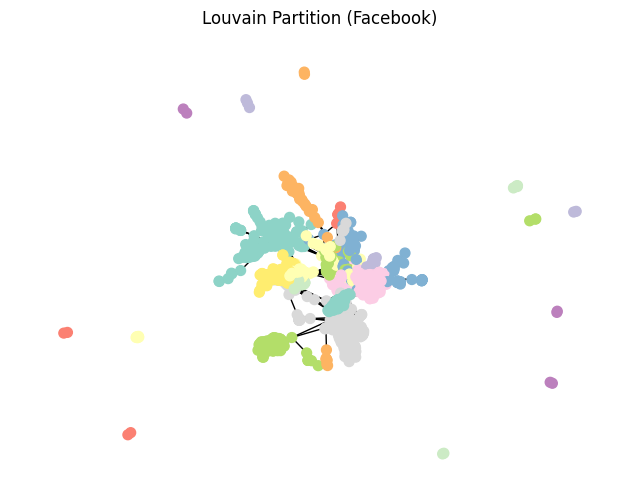

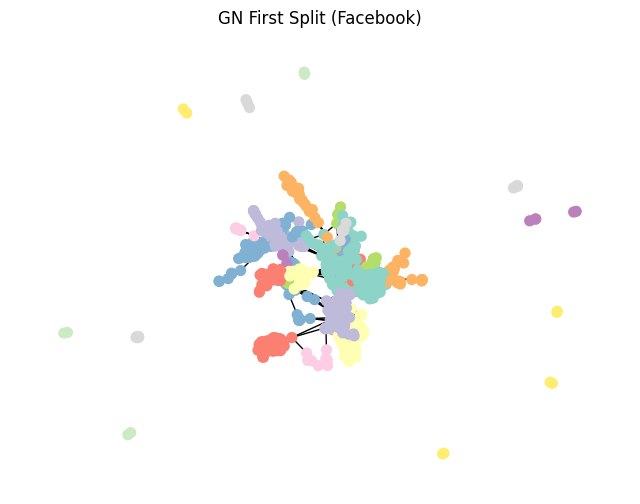

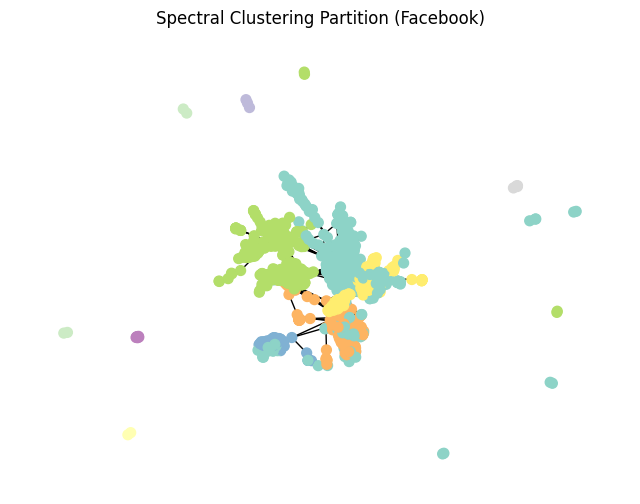

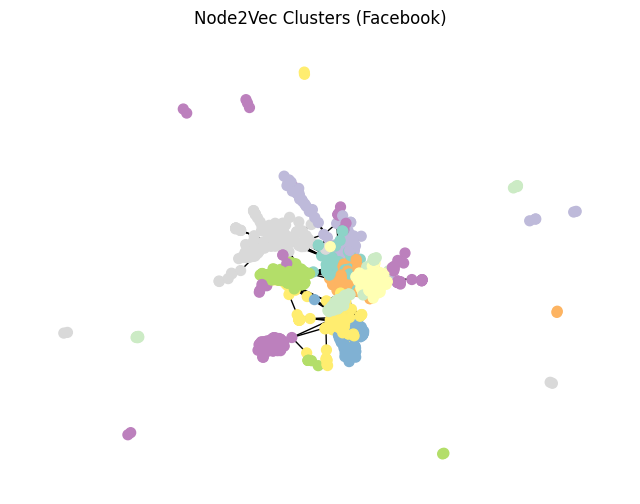

In [14]:
# ====================
# FACEBOOK
# ====================
visualize_communities(G_facebook, results_f['louvain_partition'], title="Louvain Partition (Facebook)")
#analyze_community_attributes(G_facebook, results_f['louvain_partition'], attribute_name="location")

visualize_communities(G_facebook, results_f['leiden_partition_dict'], title="GN First Split (Facebook)")
#analyze_community_attributes(G_facebook, results_f['leiden_partition_dict'], attribute_name="location")

# Build dict for Spectral approach
spectral_dict_f = dict(zip(
    results_f['spectral_df']['Node'],
    results_f['spectral_df']['Cluster']
))
visualize_communities(G_facebook, spectral_dict_f, title="Spectral Clustering Partition (Facebook)")
#analyze_community_attributes(G_facebook, spectral_dict_f, attribute_name="location")

# Build dict for Node2Vec
node2vec_partition_f = dict(zip(
    results_f['node2vec_df']['Node'],
    results_f['node2vec_df']['Cluster']
))
visualize_communities(G_facebook, node2vec_partition_f, title="Node2Vec Clusters (Facebook)")
#analyze_community_attributes(G_facebook, node2vec_partition_f, attribute_name="location")

In [ ]:
# ====================
# TWITTER - he is to big to represented
# ====================
""" visualize_sampled_graph(G_twitter, results_t['louvain_partition'], title="Louvain Partition (Twitter)")

visualize_sampled_graph(G_twitter, results_t['leiden_partition_dict'], title="GN First Split (Twitter)")


# Build dict for Spectral approach
spectral_dict_t = dict(zip(
    results_t['spectral_df']['Node'],
    results_t['spectral_df']['Cluster']
))
visualize_sampled_graph(G_twitter, spectral_dict_t, title="Spectral Clustering Partition (Twitter)")

# Build dict for Node2Vec
node2vec_partition_t = dict(zip(
    results_t['node2vec_df']['Node'],
    results_t['node2vec_df']['Cluster']
))
visualize_sampled_graph(G_twitter, node2vec_partition_t, title="Node2Vec Clusters (Twitter)") """


## Graph Embeddings (GNN-Based Approaches)

In this new section, we explore **Graph Neural Networks (GNNs)** for generating node embeddings. Unlike shallow embedding techniques (e.g., Node2Vec), GNNs learn from both node features and graph structure by applying **message passing** or **convolution-like** operations across the network.

Here, we will introduce two common GNN variants:
1. **GCN (Graph Convolutional Network)**
2. **R-GCN (Relational Graph Convolutional Network)**

We will show how to implement these models in PyTorch (using minimal dependencies) to obtain node embeddings for **Zachary’s Karate Club**, **Facebook**, and **Twitter** graphs. Finally, we will illustrate how to cluster the resulting embeddings and evaluate them.


### 1. Theoretical Background

#### 1.1 Graph Convolutional Network (GCN)

A **Graph Convolutional Network** (GCN) is a spectral-based approach that generalizes convolutions to graph-structured data. A simplified 2-layer GCN model for node embeddings can be written as:

$$
    H^{(1)} = \sigma\bigl(\tilde{D}^{-1/2}\,\tilde{A}\,\tilde{D}^{-1/2}\,X\,W^{(0)}\bigr),
$$
$$
    H^{(2)} = \mathrm{softmax}\bigl(\tilde{D}^{-1/2}\,\tilde{A}\,\tilde{D}^{-1/2}\,H^{(1)}\,W^{(1)}\bigr),
$$

where:
- $ \tilde{A} = A + I $ is the adjacency matrix with added self-loops.
- $\tilde{D}$ is the diagonal degree matrix of  $\tilde{A}$.
- $X$ is the matrix of node features.
- $W^{(0)}$ and  $W^{(1)}$ are learnable weight matrices.
- $\sigma(\cdot)$ is a non-linear activation (e.g., ReLU).

In practice, if we only want to obtain embeddings (not classifications), we can omit the final softmax and use the hidden representation $H^{(1)}$ or $H^{(2)}$ as the node embeddings.

---

#### 1.2 Relational GCN (R-GCN)

**R-GCN** extends GCNs to handle **multi-relation** or **heterogeneous** graphs by learning distinct weights for different edge types (relations). For example, if you have relationships like *follows*, *likes*, and *mentions* in a social media graph, R-GCN can model each relation differently. Its forward pass is conceptually:

$$
    h_i^{(l+1)} = \sigma \Bigl( \sum_{r \in \mathcal{R}} \sum_{j \in \mathcal{N}_i^r} \frac{1}{c_{i,r}} W_r^{(l)} h_j^{(l)} \Bigr),
$$

where:
- $ \mathcal{R} $ is the set of relation types.
- $ \mathcal{N}_i^r $ are the neighbors of node $ i $ under relation $ r $.
- $ W_r^{(l)} $ is the learnable weight matrix for relation $ r $ at layer $ l $.
- $ c_{i,r} $ is a normalization constant (e.g., node degrees).

For simplicity in this notebook, we will treat all edges as a single relation or show how you **would** extend the code if multiple relations existed. Even if your graph has only one edge type (like a typical social network), the R-GCN approach can still be applied (albeit with only one relation type).

---

### Implementation Details
- We use **PyTorch** for defining and training GCN-like layers.
- Since we lack explicit node features in many social network datasets, we will use **identity features** or **one-hot** vectors for each node (i.e., a dimension = number of nodes). This is a common trick for demonstration if no other features exist.
- After training, we extract each node’s embedding from the final hidden layer of the GNN.
- We then apply **K-Means** to the learned embeddings and compute a **silhouette score** for cluster quality, analogous to what we did with Node2Vec or spectral methods.

### 2. Installing and Importing Dependencies

Below, we install the PyTorch library (if not available) and import the necessary modules. We also import `KMeans` and `silhouette_score` as before.


In [24]:
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
import scipy.sparse as sp
from networkx.convert_matrix import to_scipy_sparse_array

### 3. Defining a GNN Model Class

We create a class `GraphEmbedderGNN` that can train either a simple **GCN** or a **Relational GCN (R-GCN)**. For simplicity:
- We treat each edge as a single relation unless specified otherwise (the code can be extended for multiple relations).
- We use a single hidden layer (configurable) to obtain embeddings.
- We have utility methods:
  - `prepare_data(G)` to build adjacency matrices, features, etc.
  - `forward(...)` that defines the GCN or R-GCN layer pass.
  - `train_model(...)` that runs a simple training loop (here, we do a reconstruction or embedding objective).
  - `get_embeddings(...)` to extract the node embeddings after training.


In [25]:
class GraphEmbedderGNN(nn.Module):
    def __init__(self, 
                 num_nodes, 
                 embed_dim=16, 
                 model_type='GCN',  # or 'RGCN'
                 num_relations=1):
        """
        :param num_nodes: Number of nodes in the graph
        :param embed_dim: Dimension of the output embeddings
        :param model_type: 'GCN' or 'RGCN'
        :param num_relations: If 'RGCN', how many relations do we have? (default=1 for single-edge-type)
        """
        super().__init__()
        self.model_type = model_type
        self.num_nodes = num_nodes
        self.embed_dim = embed_dim
        self.num_relations = num_relations
        
        # For demonstration, a single-layer GCN or R-GCN
        if model_type == 'GCN':
            # Basic GCN weight: [in_feats, out_feats], here in_feats = num_nodes if using one-hot
            self.W = nn.Parameter(torch.randn(num_nodes, embed_dim) * 0.01)
        else:  # R-GCN
            # We can store a weight matrix for each relation
            # For single relation, same as GCN. For multiple, we sum them up.
            self.W_rel = nn.ParameterList([
                nn.Parameter(torch.randn(num_nodes, embed_dim) * 0.01) 
                for _ in range(num_relations)
            ])
        
        # Optionally define a non-linearity
        self.relu = nn.ReLU()
    
    def forward(self, features, adj_mats):
        """
        :param features: Node feature matrix (num_nodes x num_nodes if using identity)
        :param adj_mats: A list or single adjacency matrix
        :return: Node embeddings (num_nodes x embed_dim)
        """
        if self.model_type == 'GCN':
            # A ~ (D^-1/2) A (D^-1/2), but we keep it simple
            # out = A * X * W
            A = adj_mats  # single adjacency matrix
            # features: [num_nodes x num_nodes], W: [num_nodes x embed_dim]
            out = A @ features @ self.W
            return self.relu(out)
        
        else:  # R-GCN
            # If single relation, same as GCN, else sum over relations
            out = 0
            for i, A_rel in enumerate(adj_mats):
                # A_rel * features * W_rel[i]
                out = out + A_rel @ features @ self.W_rel[i]
            return self.relu(out)
    
    def train_model(self, 
                    adj_matrix, 
                    epochs=50, 
                    lr=0.01):
        """
        A simple training routine. We can optimize for embedding similarity or 
        adjacency reconstruction, etc. For demonstration, we'll do adjacency 
        reconstruction via an inner product decoder: we try to predict A from Z * Z^T.
        """
        # If R-GCN, adj_matrix might be a list of adjacency matrices. If GCN, it's a single matrix.
        # Build input features: identity for each node
        features = torch.eye(self.num_nodes)
        
        # Put everything on CPU (or GPU if desired)
        if isinstance(adj_matrix, list):
            A_list = [torch.FloatTensor(A.toarray()) for A in adj_matrix]
        else:
            A_list = [torch.FloatTensor(adj_matrix.toarray())]
        
        # Our adjacency ground truth
        if len(A_list) == 1:
            A_gt = A_list[0]
        else:
            # Sum or combine them if multiple relations
            A_gt = sum(A_list)
        
        optimizer = optim.Adam(self.parameters(), lr=lr)
        loss_fn = nn.MSELoss()
        
        for epoch in range(epochs):
            optimizer.zero_grad()
            # Forward
            Z = self.forward(features, A_list[0] if self.model_type=='GCN' else A_list)
            
            # Reconstruct adjacency: A_pred = Z Z^T
            A_pred = Z @ Z.T  # [num_nodes x num_nodes]
            
            loss = loss_fn(A_pred, A_gt)
            loss.backward()
            optimizer.step()
            
            if (epoch+1) % 10 == 0:
                print(f"Epoch {epoch+1}/{epochs} - Loss: {loss.item():.4f}")
    
    def get_embeddings(self, adj_matrix):
        """
        After training, get the node embeddings from the forward pass.
        """
        if isinstance(adj_matrix, list):
            A_list = [torch.FloatTensor(A.toarray()) for A in adj_matrix]
        else:
            A_list = [torch.FloatTensor(adj_matrix.toarray())]
        
        features = torch.eye(self.num_nodes)
        Z = self.forward(features, A_list[0] if self.model_type=='GCN' else A_list)
        return Z.detach().numpy()


### 4. Utility Function: `gnn_embedding_clustering`

We create a helper function that:
1. Builds a GNN model (`GraphEmbedderGNN`).
2. Prepares the adjacency matrix (or matrices) and trains the model.
3. Extracts the embeddings.
4. Performs K-Means clustering.
5. Computes the silhouette score.

We'll then apply this function to each of the three graphs:
- Karate Club
- Facebook
- Twitter


In [26]:
def gnn_embedding_clustering(G, 
                             model_type='GCN',
                             embed_dim=16, 
                             epochs=50, 
                             lr=0.01, 
                             k=3,
                             num_relations=1):
    """
    :param G: A NetworkX graph (undirected or directed)
    :param model_type: 'GCN' or 'RGCN'
    :param embed_dim: GNN embedding dimension
    :param epochs: training epochs
    :param lr: learning rate
    :param k: K-Means clusters
    :param num_relations: For R-GCN, how many distinct relations (default=1)
    
    :return: (labels, sil_score, df_gnn) -> cluster labels, silhouette, dataframe of Node->Cluster
    """
    # 1) Convert the NetworkX graph to a NumPy array
    A_array = to_scipy_sparse_array(G, nodelist=sorted(G.nodes()))
    # Convert to a sparse CSR matrix
    A = sp.csr_matrix(A_array)
    # Add self-loops
    A.setdiag(1)

    # 2) Create the GNN model
    num_nodes = G.number_of_nodes()
    gnn_model = GraphEmbedderGNN(num_nodes=num_nodes, 
                                 embed_dim=embed_dim, 
                                 model_type=model_type,
                                 num_relations=num_relations)
    
    # 3) Train the model
    gnn_model.train_model(A, epochs=epochs, lr=lr)
    
    # 4) Extract embeddings
    Z = gnn_model.get_embeddings(A)  # shape [num_nodes, embed_dim]
    
    # 5) K-Means & silhouette
    kmeans = KMeans(n_clusters=k, random_state=42)
    labels = kmeans.fit_predict(Z)
    sil = silhouette_score(Z, labels) if k > 1 else 0.0
    
    # 6) Build DataFrame of (Node, Cluster)
    nodes_list = sorted(G.nodes())
    df_gnn = pd.DataFrame({'Node': nodes_list, 'Cluster': labels})
    
    return labels, sil, df_gnn


### 5. Running GNN Embeddings on the Three Graphs

We will now apply **GCN** embeddings to:
1. **Zachary’s Karate Club**
2. **Facebook** network
3. **Twitter** network (directed)

After that, we will demonstrate **R-GCN** in a similar fashion (although we only have 1 relation in these datasets, it is structurally the same as GCN).


In [66]:
# ======== GCN on Karate ========
print("=== GCN on Zachary's Karate Club ===")
labels_karate_gcn, sil_karate_gcn, df_karate_gcn = gnn_embedding_clustering(
    G_karate, 
    model_type='GCN', 
    embed_dim=8, 
    epochs=50, 
    lr=0.01, 
    k=2
)
print(f"GCN Embeddings Silhouette (Karate, k=3): {sil_karate_gcn:.4f}")
print(df_karate_gcn.groupby('Cluster')['Node'].apply(list))

=== GCN on Zachary's Karate Club ===
Epoch 10/50 - Loss: 0.7288
Epoch 20/50 - Loss: 0.5900
Epoch 30/50 - Loss: 0.5436
Epoch 40/50 - Loss: 0.5298
Epoch 50/50 - Loss: 0.5205
GCN Embeddings Silhouette (Karate, k=3): 0.2707
Cluster
0    [0, 1, 2, 3, 4, 5, 6, 7, 10, 11, 12, 13, 16, 1...
1    [8, 9, 14, 15, 18, 20, 22, 23, 24, 25, 26, 27,...
Name: Node, dtype: object


In [ ]:
# ======== GCN on Facebook ========
print("\n=== GCN on Facebook ===")
labels_facebook_gcn, sil_facebook_gcn, df_facebook_gcn = gnn_embedding_clustering(
    G_facebook,
    model_type='GCN',
    embed_dim=8,
    epochs=50,
    lr=0.01,
    k=5
)
print(f"GCN Embeddings Silhouette (Facebook, k=10): {sil_facebook_gcn:.4f}")
print("Cluster sizes:\n", df_facebook_gcn['Cluster'].value_counts())


=== GCN on Facebook ===


KeyboardInterrupt: 

In [33]:
# # ======== GCN on Twitter ========
# print("\n=== GCN on Twitter (treated as undirected for adjacency) ===")
# labels_twitter_gcn, sil_twitter_gcn, df_twitter_gcn = gnn_embedding_clustering(
#     G_twitter,
#     model_type='GCN',
#     embed_dim=8,
#     epochs=30,
#     lr=0.01,
#     k=3
# )
# print(f"GCN Embeddings Silhouette (Twitter, k=3): {sil_twitter_gcn:.4f}")
# print("Cluster sizes:\n", df_twitter_gcn['Cluster'].value_counts())

### 5.1 Visualizing GCN Clusters

We can reuse our existing `visualize_communities` function by mapping each node to its GCN-derived cluster label. This is purely optional if the graph is not too large.


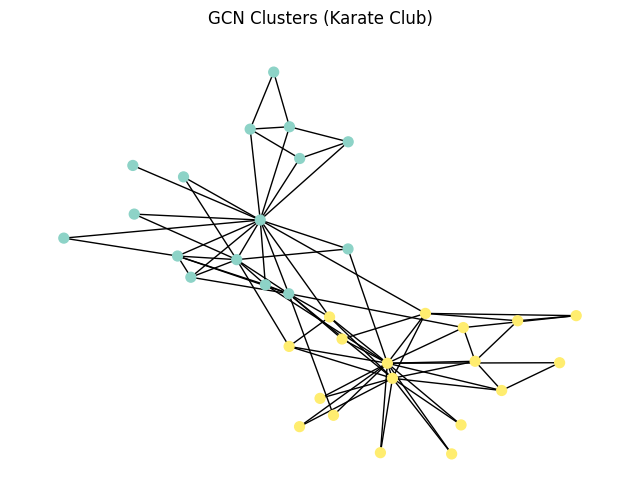

In [68]:
# GCN Visualization for Karate
gcn_partition_karate = dict(zip(df_karate_gcn['Node'], df_karate_gcn['Cluster']))
visualize_communities(G_karate, gcn_partition_karate, title="GCN Clusters (Karate Club)")

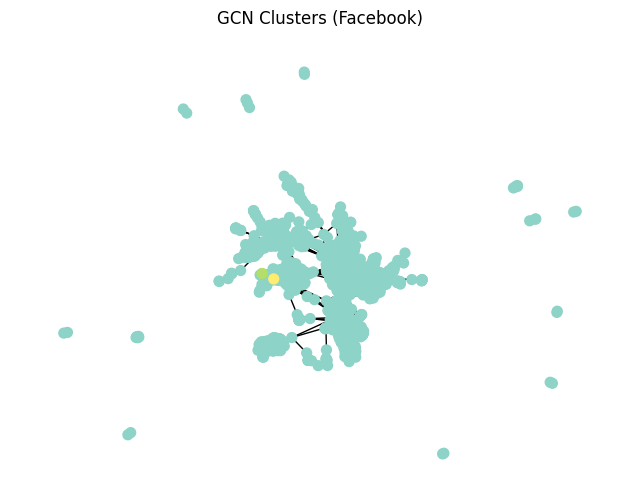

In [37]:
# GCN Visualization for Facebook
gcn_partition_facebook = dict(zip(df_facebook_gcn['Node'], df_facebook_gcn['Cluster']))
visualize_communities(G_facebook, gcn_partition_facebook, title="GCN Clusters (Facebook)")

### 6 R-GCN on the Same Graphs

We only have one edge type in these datasets, so running R-GCN with `num_relations=1` will effectively replicate GCN. However, if you had multiple edge types, you would pass a list of adjacency matrices or keep track of the relation for each edge.

Below, we show how it would look for the Karate graph. The usage for Facebook and Twitter is analogous.


=== R-GCN on Karate (single relation) ===
Epoch 10/50 - Loss: 0.7133
Epoch 20/50 - Loss: 0.5963
Epoch 30/50 - Loss: 0.5415
Epoch 40/50 - Loss: 0.5205
Epoch 50/50 - Loss: 0.5037
R-GCN Embeddings Silhouette (Karate, k=3): 0.3268
Cluster
0    [4, 5, 6, 9, 10, 11, 12, 14, 15, 16, 17, 18, 1...
1                                      [8, 23, 32, 33]
2                                  [0, 1, 2, 3, 7, 13]
Name: Node, dtype: object


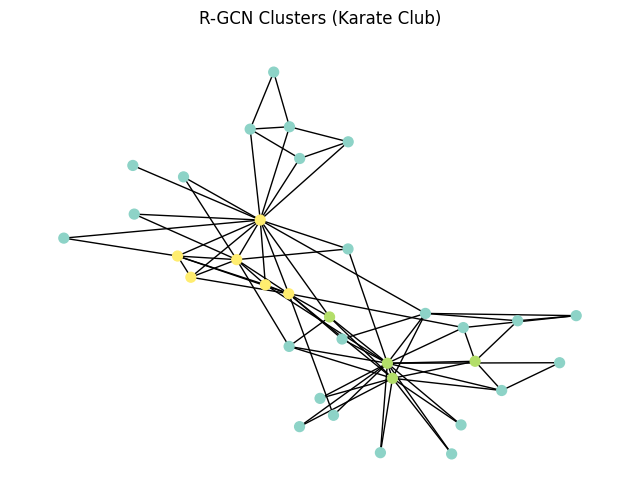

In [46]:
print("=== R-GCN on Karate (multiple relations) ===")
labels_karate_rgcn, sil_karate_rgcn, df_karate_rgcn = gnn_embedding_clustering(
    G_karate,
    model_type='RGCN',
    embed_dim=8,
    epochs=100,
    lr=0.01,
    k=3,
    num_relations=5
)
print(f"R-GCN Embeddings Silhouette (Karate, k=3): {sil_karate_rgcn:.4f}")
print(df_karate_rgcn.groupby('Cluster')['Node'].apply(list))

# Visualize
rgcn_partition_karate = dict(zip(df_karate_rgcn['Node'], df_karate_rgcn['Cluster']))
visualize_communities(G_karate, rgcn_partition_karate, title="R-GCN Clusters (Karate Club)") 


In [48]:
print("=== R-GCN on Facebook (multiple relations) ===")
labels_facebook_rgcn, sil_facebook_rgcn, df_facebook_rgcn = gnn_embedding_clustering(
    G_facebook,
    model_type='RGCN',
    embed_dim=8,
    epochs=50,
    lr=0.1,
    k=10,
    num_relations=5
)
print(f"R-GCN Embeddings Silhouette (Facebook, k=10): {sil_facebook_rgcn:.4f}")
print(df_facebook_rgcn.groupby('Cluster')['Node'].apply(list))

# Visualize
rgcn_partition_facebook = dict(zip(df_facebook_rgcn['Node'], df_facebook_rgcn['Cluster']))
visualize_communities(G_facebook, rgcn_partition_facebook, title="R-GCN Clusters (Facebook Club)") 


=== R-GCN on Facebook (multiple relations) ===
Epoch 10/50 - Loss: 0.0110
Epoch 20/50 - Loss: 0.0110
Epoch 30/50 - Loss: 0.0110
Epoch 40/50 - Loss: 0.0110
Epoch 50/50 - Loss: 0.0110


c:\Users\Joao Pedro\Desktop\Agenda-Guia\CS\3A\Mention\2025.1.2\Graph Mining\graph_facebook_analysis\venv\lib\site-packages\sklearn\base.py:1389: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (10). Possibly due to duplicate points in X.
  return fit_method(estimator, *args, **kwargs)


ValueError: Number of labels is 1. Valid values are 2 to n_samples - 1 (inclusive)

In [58]:
# Make sure to install torch and torch_geometric if not already installed:
#%pip install torch torch_geometric

import torch
from torch import nn
import torch.nn.functional as F
from torch_geometric.nn import GCNConv, RGCNConv
import numpy as np
from torch_geometric.data import Data
from torch_geometric.utils import from_networkx, negative_sampling

import networkx as nx

# def nx_to_data(G):
#     """
#     Converts a NetworkX graph to a PyTorch Geometric Data object.
#     Uses node degree as a 1-dimensional feature for each node.
#     For R-GCN, all edges are given a default relation type 0.
#     """
#     data = from_networkx(G)
#     # If no node feature exists, create a feature using node degree
#     if not hasattr(data, 'x'):
#         degrees = np.array([deg for _, deg in G.degree()])
#         data.x = torch.tensor(degrees, dtype=torch.float).view(-1, 1)
#     # For R-GCN: assign edge_type = 0 for all edges
#     data.edge_type = torch.zeros(data.edge_index.size(1), dtype=torch.long)
#     data.num_nodes = G.number_of_nodes()
#     return data

def nx_to_data(G):
    """
    Converts a NetworkX graph to a PyTorch Geometric Data object.
    Uses node degree as a 1-dimensional feature for each node.
    For R-GCN, all edges are given a default relation type 0.
    """

    data = from_networkx(G)
    
    # If no node feature exists, create a feature using node degree.
    if not hasattr(data, 'x') or data.x is None:
        degrees = np.array([deg for _, deg in G.degree()])
        data.x = torch.tensor(degrees, dtype=torch.float).view(-1, 1)
    
    # If edge_index is missing, create it manually.
    if not hasattr(data, 'edge_index') or data.edge_index is None:
        # Build edge_index from graph edges
        edge_index = torch.tensor(list(G.edges()), dtype=torch.long).t().contiguous()
        # For undirected graphs, add reverse edges
        if not G.is_directed():
            edge_index_rev = edge_index[[1, 0], :]
            edge_index = torch.cat([edge_index, edge_index_rev], dim=1)
        data.edge_index = edge_index

    # For R-GCN: assign edge_type = 0 for every edge.
    data.edge_type = torch.zeros(data.edge_index.size(1), dtype=torch.long)
    
    # Ensure number of nodes is set.
    data.num_nodes = G.number_of_nodes()
    return data


In [59]:
class GNNEmbeddingTrainer(nn.Module):
    def __init__(self, in_channels, hidden_channels, out_channels, num_layers=2, model_type='GCN'):
        """
        Builds a multi-layer GCN or R-GCN.
        
        Parameters:
        - in_channels: Dimension of input node features.
        - hidden_channels: Number of hidden units.
        - out_channels: Dimension of the output node embeddings.
        - num_layers: Total number of layers (minimum 2).
        - model_type: Either 'GCN' or 'RGCN'.
        """
        super(GNNEmbeddingTrainer, self).__init__()
        self.model_type = model_type

        self.convs = torch.nn.ModuleList()
        if model_type == 'GCN':
            # First layer
            self.convs.append(GCNConv(in_channels, hidden_channels))
            # Middle layers
            for _ in range(num_layers - 2):
                self.convs.append(GCNConv(hidden_channels, hidden_channels))
            # Final layer
            self.convs.append(GCNConv(hidden_channels, out_channels))
        elif model_type == 'RGCN':
            # First layer: assume 1 relation for homogeneous data
            self.convs.append(RGCNConv(in_channels, hidden_channels, num_relations=1))
            for _ in range(num_layers - 2):
                self.convs.append(RGCNConv(hidden_channels, hidden_channels, num_relations=1))
            self.convs.append(RGCNConv(hidden_channels, out_channels, num_relations=1))
        else:
            raise ValueError("model_type must be 'GCN' or 'RGCN'.")

    def forward(self, x, edge_index, edge_type=None):
        # Forward propagation through the network
        for conv in self.convs[:-1]:
            if self.model_type == 'GCN':
                x = conv(x, edge_index)
            else:  # RGCN requires edge_type input
                x = conv(x, edge_index, edge_type)
            x = F.relu(x)
        # Final layer (no activation)
        if self.model_type == 'GCN':
            x = self.convs[-1](x, edge_index)
        else:
            x = self.convs[-1](x, edge_index, edge_type)
        return x


class GNNEmbedder:
    def __init__(self, in_channels, hidden_channels=16, out_channels=16, num_layers=2, model_type='GCN', lr=0.01, epochs=200):
        """
        Wrapper class that trains a GNN model (GCN or R-GCN) to obtain node embeddings.
        
        Parameters:
        - in_channels: Input feature dimension.
        - hidden_channels: Number of hidden units.
        - out_channels: Embedding dimension.
        - num_layers: Number of GNN layers.
        - model_type: 'GCN' or 'RGCN'.
        - lr: Learning rate.
        - epochs: Number of training epochs.
        """
        self.model = GNNEmbeddingTrainer(in_channels, hidden_channels, out_channels, num_layers, model_type)
        self.lr = lr
        self.epochs = epochs
        self.model_type = model_type

    def train(self, data):
        """
        Trains the model to reconstruct the edge structure.
        Uses a dot-product decoder and binary cross entropy loss.
        """
        optimizer = torch.optim.Adam(self.model.parameters(), lr=self.lr)
        self.model.train()

        for epoch in range(self.epochs):
            optimizer.zero_grad()
            if self.model_type == 'GCN':
                embeddings = self.model(data.x, data.edge_index)
            else:  # RGCN
                embeddings = self.model(data.x, data.edge_index, data.edge_type)
            
            # Positive (existing) edges
            pos_edge_index = data.edge_index
            # Sample negative edges
            neg_edge_index = negative_sampling(edge_index=pos_edge_index, num_nodes=data.num_nodes)
            
            # Compute scores using dot product
            pos_scores = (embeddings[pos_edge_index[0]] * embeddings[pos_edge_index[1]]).sum(dim=1)
            neg_scores = (embeddings[neg_edge_index[0]] * embeddings[neg_edge_index[1]]).sum(dim=1)
            
            # Compute reconstruction loss with numerical stability additions (epsilon)
            epsilon = 1e-15
            pos_loss = -torch.log(torch.sigmoid(pos_scores) + epsilon).mean()
            neg_loss = -torch.log(1 - torch.sigmoid(neg_scores) + epsilon).mean()
            loss = pos_loss + neg_loss

            loss.backward()
            optimizer.step()

            if (epoch + 1) % (self.epochs // 10) == 0 or epoch == 0:
                print(f"Epoch {epoch + 1}/{self.epochs}, Loss: {loss.item():.4f}")

        self.model.eval()
        with torch.no_grad():
            if self.model_type == 'GCN':
                embeddings = self.model(data.x, data.edge_index)
            else:
                embeddings = self.model(data.x, data.edge_index, data.edge_type)
        return embeddings


In [60]:
# Convert graphs using the helper function defined earlier
G_karate_data = nx_to_data(nx.karate_club_graph())

# Define parameters for the embedding model.
in_channels = 1          # Since we use the degree as a 1-dimensional feature.
hidden_channels = 16     
out_channels = 16        
num_layers = 3           
lr = 0.01                
epochs = 100

print("=== GCN Embeddings ===\n")

print("Zachary's Karate Club (GCN)")
gnn_embedder_karate = GNNEmbedder(in_channels, hidden_channels, out_channels, num_layers, model_type='GCN', lr=lr, epochs=epochs)
embeddings_karate_gcn = gnn_embedder_karate.train(G_karate_data)
print("Embedding shape:", embeddings_karate_gcn.shape, "\n")

print("=== R-GCN Embeddings ===\n")

print("Zachary's Karate Club (R-GCN)")
gnn_embedder_karate_rgcn = GNNEmbedder(in_channels, hidden_channels, out_channels, num_layers, model_type='RGCN', lr=lr, epochs=epochs)
embeddings_karate_rgcn = gnn_embedder_karate_rgcn.train(G_karate_data)
print("Embedding shape:", embeddings_karate_rgcn.shape, "\n")

=== GCN Embeddings ===

Zachary's Karate Club (GCN)
Epoch 1/100, Loss: 32.7485
Epoch 10/100, Loss: 1.5298
Epoch 20/100, Loss: 1.3648
Epoch 30/100, Loss: 1.3470
Epoch 40/100, Loss: 1.3551
Epoch 50/100, Loss: 1.3409
Epoch 60/100, Loss: 1.3282
Epoch 70/100, Loss: 1.3081
Epoch 80/100, Loss: 1.2913
Epoch 90/100, Loss: 1.2920
Epoch 100/100, Loss: 1.2999
Embedding shape: torch.Size([34, 16]) 

=== R-GCN Embeddings ===

Zachary's Karate Club (R-GCN)
Epoch 1/100, Loss: 34.5388
Epoch 10/100, Loss: 34.5388
Epoch 20/100, Loss: 34.5388
Epoch 30/100, Loss: 34.5388
Epoch 40/100, Loss: 34.5388
Epoch 50/100, Loss: 34.5388
Epoch 60/100, Loss: 34.5388
Epoch 70/100, Loss: 34.5388
Epoch 80/100, Loss: 34.5388
Epoch 90/100, Loss: 34.5388
Epoch 100/100, Loss: 34.5388
Embedding shape: torch.Size([34, 16]) 



In [61]:
# Convert graphs using the helper function defined earlier
G_facebook_data = nx_to_data(load_graph())  # Assumes load_graph() returns a NetworkX graph for Facebook.

# Define parameters for the embedding model.
in_channels = 1          # Since we use the degree as a 1-dimensional feature.
hidden_channels = 16     
out_channels = 16        
num_layers = 3           
lr = 0.01                
epochs = 100             # For demonstration; adjust epochs as needed

print("=== GCN Embeddings ===\n")

print("Facebook (GCN)")
gnn_embedder_facebook = GNNEmbedder(in_channels, hidden_channels, out_channels, num_layers, model_type='GCN', lr=lr, epochs=epochs)
embeddings_facebook_gcn = gnn_embedder_facebook.train(G_facebook_data)
print("Embedding shape:", embeddings_facebook_gcn.shape, "\n")

print("=== R-GCN Embeddings ===\n")

print("Facebook (R-GCN)")
gnn_embedder_facebook_rgcn = GNNEmbedder(in_channels, hidden_channels, out_channels, num_layers, model_type='RGCN', lr=lr, epochs=epochs)
embeddings_facebook_rgcn = gnn_embedder_facebook_rgcn.train(G_facebook_data)
print("Embedding shape:", embeddings_facebook_rgcn.shape, "\n")

=== GCN Embeddings ===

Facebook (GCN)
Epoch 1/100, Loss: 33.7938
Epoch 10/100, Loss: 9.9564
Epoch 20/100, Loss: 1.3061
Epoch 30/100, Loss: 1.2400
Epoch 40/100, Loss: 1.2049
Epoch 50/100, Loss: 1.1670
Epoch 60/100, Loss: 1.1427
Epoch 70/100, Loss: 1.1369
Epoch 80/100, Loss: 1.1150
Epoch 90/100, Loss: 1.1102
Epoch 100/100, Loss: 1.1008
Embedding shape: torch.Size([3959, 16]) 

=== R-GCN Embeddings ===

Facebook (R-GCN)
Epoch 1/100, Loss: 34.5292
Epoch 10/100, Loss: 18.5157
Epoch 20/100, Loss: 1.4268
Epoch 30/100, Loss: 1.3898
Epoch 40/100, Loss: 1.3889
Epoch 50/100, Loss: 1.3884
Epoch 60/100, Loss: 1.3880
Epoch 70/100, Loss: 1.3876
Epoch 80/100, Loss: 1.3873
Epoch 90/100, Loss: 1.3871
Epoch 100/100, Loss: 1.3870
Embedding shape: torch.Size([3959, 16]) 



## Visualizing GNN Embeddings

In this cell we reuse the existing `visualize_communities` function to visualize node clusters based on the GNN embeddings. We proceed as follows:
1. Convert the GNN embeddings (a PyTorch tensor) to a NumPy array.
2. Apply **K-Means clustering** on the embeddings to obtain a cluster label for each node.
3. Build a partition dictionary mapping each node (assuming the ordering in the original NetworkX graph) to its cluster label.
4. Call the `visualize_communities` function to display the graph with nodes color-coded by their cluster assignment.

This approach allows you to assess visually whether the learned embeddings capture meaningful community structure.


Visualizing GCN Embedding Clusters for Zachary's Karate Club:


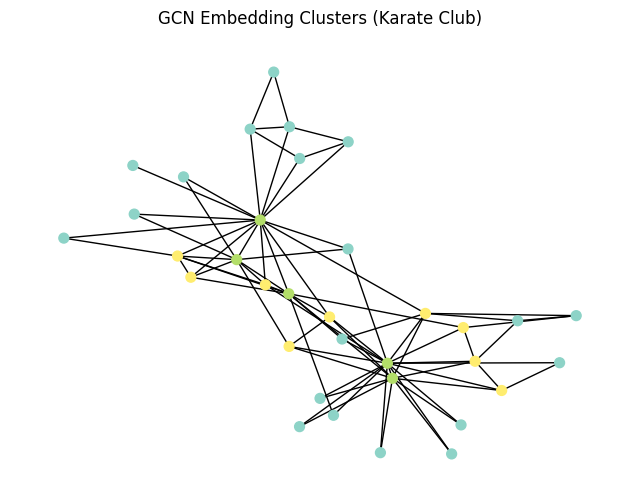

Visualizing R-GCN Embedding Clusters for Zachary's Karate Club:


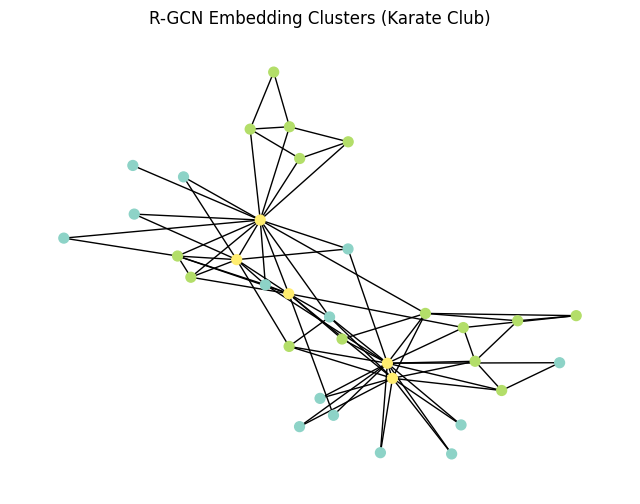

In [62]:
from sklearn.cluster import KMeans

def visualize_gnn_embeddings(G, embeddings, title="GNN Embedding Clusters", n_clusters=3):
    """
    Reuse the visualize_communities function to visualize clusters determined by KMeans on GNN embeddings.
    
    Parameters:
        - G: Original NetworkX graph.
        - embeddings: torch.Tensor of shape (num_nodes, embedding_dim) produced by your GNN model.
        - title: Title for the plot.
        - n_clusters: Number of clusters to use with KMeans.
    """
    # Convert embeddings to NumPy format
    embeddings_np = embeddings.cpu().detach().numpy()
    
    # Apply KMeans clustering on the embeddings
    kmeans = KMeans(n_clusters=n_clusters, random_state=42)
    labels = kmeans.fit_predict(embeddings_np)
    
    # Build partition dictionary mapping each node to a cluster label
    # Here, we assume that the ordering of nodes in G.nodes() corresponds to the order in the embeddings tensor.
    nodes_list = list(G.nodes())
    partition = {node: int(label) for node, label in zip(nodes_list, labels)}
    
    # Call the existing visualize_communities function to display the result.
    visualize_communities(G, partition, title=title)

# Example usage:
# For demonstration, we visualize results on Zachary's Karate Club graph using embeddings from the GCN and R-GCN models.

print("Visualizing GCN Embedding Clusters for Zachary's Karate Club:")
# Assuming embeddings_karate_gcn is the output tensor from your GCN embedding model
visualize_gnn_embeddings(nx.karate_club_graph(), embeddings_karate_gcn, 
                         title="GCN Embedding Clusters (Karate Club)", n_clusters=3)

print("Visualizing R-GCN Embedding Clusters for Zachary's Karate Club:")
# Assuming embeddings_karate_rgcn is the output tensor from your R-GCN embedding model
visualize_gnn_embeddings(nx.karate_club_graph(), embeddings_karate_rgcn, 
                         title="R-GCN Embedding Clusters (Karate Club)", n_clusters=3)


Visualizing GCN Embedding Clusters for Facebook Graph:


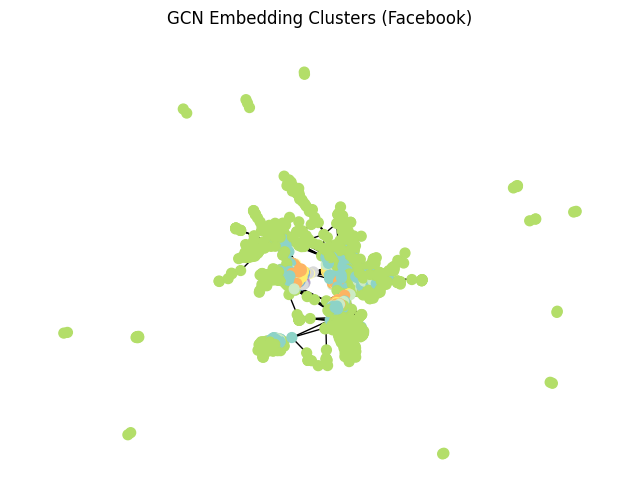

Visualizing R-GCN Embedding Clusters for Facebook Graph:


c:\Users\Joao Pedro\Desktop\Agenda-Guia\CS\3A\Mention\2025.1.2\Graph Mining\graph_facebook_analysis\venv\lib\site-packages\sklearn\base.py:1389: ConvergenceWarning: Number of distinct clusters (9) found smaller than n_clusters (10). Possibly due to duplicate points in X.
  return fit_method(estimator, *args, **kwargs)


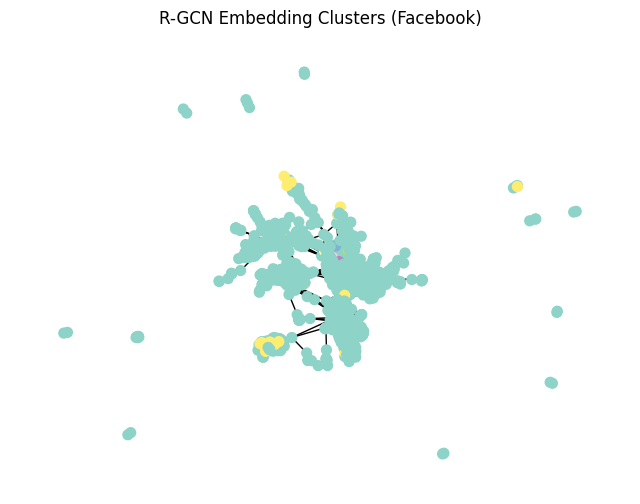

In [63]:
print("Visualizing GCN Embedding Clusters for Facebook Graph:")
visualize_gnn_embeddings(G_facebook, embeddings_facebook_gcn, 
                         title="GCN Embedding Clusters (Facebook)", n_clusters=10)

print("Visualizing R-GCN Embedding Clusters for Facebook Graph:")
visualize_gnn_embeddings(G_facebook, embeddings_facebook_rgcn, 
                         title="R-GCN Embedding Clusters (Facebook)", n_clusters=10)


In [69]:
import random
import numpy as np
import scipy.sparse as sp
import networkx as nx
from networkx.convert_matrix import to_scipy_sparse_array

def sample_graph(G, max_nodes=3000, seed=42):
    """
    Return a random induced subgraph of G with up to max_nodes nodes.
    """
    random.seed(seed)
    all_nodes = list(G.nodes())
    if len(all_nodes) <= max_nodes:
        return G.copy()
    sampled_nodes = random.sample(all_nodes, max_nodes)
    return G.subgraph(sampled_nodes).copy()

def prepare_data(G):
    """
    Converts a NetworkX graph G into:
      - A (scipy CSR matrix) with self-loops
      - edges (list of (u,v)) representing positive edges
      - node_list (sorted list of nodes)
    """
    node_list = sorted(G.nodes())
    node_index = {n: i for i, n in enumerate(node_list)}

    # Build adjacency matrix
    A_array = to_scipy_sparse_array(G, nodelist=node_list)
    A = sp.csr_matrix(A_array)
    # Optionally add self loops (helpful for GCN aggregator)
    A.setdiag(1)

    # Build edges (u,v) in both directions if undirected
    edges = []
    if not G.is_directed():
        for u, v in G.edges():
            edges.append((node_index[u], node_index[v]))
            edges.append((node_index[v], node_index[u]))
    else:
        for u, v in G.edges():
            edges.append((node_index[u], node_index[v]))

    return A, edges, node_list


In [70]:
import torch
import torch.nn as nn
import torch.optim as optim

class GraphEmbedderGNN(nn.Module):
    def __init__(self, 
                 num_nodes, 
                 embed_dim=16, 
                 model_type='GCN',  # or 'RGCN'
                 num_relations=1):
        """
        Single-layer GCN or R-GCN, with learned node features and a negative-sampling training method.
        """
        super().__init__()
        self.model_type = model_type
        self.num_nodes = num_nodes
        self.embed_dim = embed_dim
        self.num_relations = num_relations
        
        # Learnable node 'input features' for each node: shape [num_nodes, embed_dim_in]
        # We'll set embed_dim_in = embed_dim to keep it simple
        self.node_features = nn.Parameter(torch.randn(num_nodes, embed_dim) * 0.01)
        
        if model_type == 'GCN':
            # Single adjacency -> single W
            # W: [embed_dim, embed_dim]
            self.W = nn.Parameter(torch.randn(embed_dim, embed_dim) * 0.01)
        else:  # R-GCN
            # If multiple relations, store multiple W
            self.W_rel = nn.ParameterList([
                nn.Parameter(torch.randn(embed_dim, embed_dim) * 0.01) 
                for _ in range(num_relations)
            ])
        
        self.relu = nn.ReLU()
    
    def forward(self, A_list):
        """
        :param A_list: list of adjacency matrices (torch.FloatTensor).
                       For GCN with single relation, it's [A].
                       For R-GCN, it can be multiple adjacency matrices.
        :return: Z -> node embeddings shape [num_nodes, embed_dim]
        """
        # Node feature matrix
        F = self.node_features  # [N, embed_dim_in]
        
        if self.model_type == 'GCN':
            A = A_list[0]  # single adjacency
            # Z = A * F * W
            Z = A @ F @ self.W
            Z = self.relu(Z)
            return Z
        else:
            # R-GCN: sum_{r} (A_r * F * W_r)
            Z_all = 0
            for i, A_r in enumerate(A_list):
                Z_part = A_r @ F @ self.W_rel[i]
                Z_all += Z_part
            Z_all = self.relu(Z_all)
            return Z_all
    
    def train_model_neg_sampling(self, 
                                 A_list, 
                                 edge_index, 
                                 epochs=50, 
                                 lr=0.01,
                                 neg_ratio=2):
        """
        Link prediction using negative sampling.
          - edge_index is a list of (u,v) for positive edges
          - We'll sample negative edges
          - BCE on dot(Z[u], Z[v]) vs label
        """
        if isinstance(A_list, list):
            A_list = [torch.FloatTensor(A.toarray()) for A in A_list]
        else:
            A_list = [torch.FloatTensor(A_list.toarray())]
        
        pos_edges = torch.LongTensor(edge_index)  # shape [E, 2]
        num_nodes = A_list[0].shape[0]
        pos_edge_count = pos_edges.shape[0]
        
        optimizer = optim.Adam(self.parameters(), lr=lr)
        bce = nn.BCEWithLogitsLoss()
        
        for epoch in range(epochs):
            # Sample negative edges
            neg_count = neg_ratio * pos_edge_count
            neg_edges = []
            tries = 0
            while len(neg_edges) < neg_count and tries < neg_count * 10:
                u = np.random.randint(0, num_nodes)
                v = np.random.randint(0, num_nodes)
                if u != v:
                    neg_edges.append((u, v))
                tries += 1
            
            neg_edges = torch.LongTensor(neg_edges)
            
            # Forward pass
            Z = self.forward(A_list)  # shape [N, embed_dim]
            
            # Scores for positive edges
            pos_u = Z[pos_edges[:,0]]
            pos_v = Z[pos_edges[:,1]]
            pos_logits = (pos_u * pos_v).sum(dim=1)  # dot-product
            
            # Scores for negative edges
            neg_u = Z[neg_edges[:,0]]
            neg_v = Z[neg_edges[:,1]]
            neg_logits = (neg_u * neg_v).sum(dim=1)
            
            # Build labels
            pos_labels = torch.ones_like(pos_logits)
            neg_labels = torch.zeros_like(neg_logits)
            
            all_logits = torch.cat([pos_logits, neg_logits], dim=0)
            all_labels = torch.cat([pos_labels, neg_labels], dim=0)
            
            loss = bce(all_logits, all_labels)
            
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
            if (epoch + 1) % 10 == 0:
                print(f"Epoch {epoch+1}/{epochs} - Loss: {loss.item():.5f}")
    
    def get_embeddings(self, A_list):
        """
        Run forward pass to get final embeddings.
        """
        if isinstance(A_list, list):
            A_list = [torch.FloatTensor(A.toarray()) for A in A_list]
        else:
            A_list = [torch.FloatTensor(A_list.toarray())]
        Z = self.forward(A_list)
        return Z.detach().numpy()


In [ ]:
import numpy as np
import pandas as pd
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

def train_and_cluster_facebook(G,
                               model_type='GCN',
                               embed_dim=32,
                               epochs=50,
                               lr=0.01,
                               k=10,
                               max_nodes=3000,
                               neg_ratio=2):
    """
    1) Subsample G (if > max_nodes)
    2) Prepare adjacency, edges
    3) Train GCN/R-GCN with negative sampling
    4) Run K-Means on embeddings
    5) Compute silhouette, return DataFrame
    """
    # Sub-sample
    if G.number_of_nodes() > max_nodes:
        G = sample_graph(G, max_nodes=max_nodes, seed=42)
        print(f"[Facebook subgraph] #Nodes={G.number_of_nodes()}, #Edges={G.number_of_edges()}")
    
    # Prepare adjacency + edges
    A, edges, node_list = prepare_data(G)
    num_nodes = len(node_list)
    
    # Create GNN
    gnn_model = GraphEmbedderGNN(num_nodes=num_nodes,
                                 embed_dim=embed_dim,
                                 model_type=model_type,
                                 num_relations=1)
    
    # Train with negative sampling
    gnn_model.train_model_neg_sampling(A, 
                                       edges,
                                       epochs=epochs,
                                       lr=lr,
                                       neg_ratio=neg_ratio)
    
    # Get embeddings
    Z = gnn_model.get_embeddings(A)  # shape [num_nodes, embed_dim]
    
    # K-Means
    if k > 1:
        kmeans = KMeans(n_clusters=k, random_state=42)
        labels = kmeans.fit_predict(Z)
        sil = silhouette_score(Z, labels)
    else:
        labels = np.zeros(num_nodes, dtype=int)
        sil = 0.0
    
    # Build DataFrame
    df_clusters = pd.DataFrame({'Node': node_list, 'Cluster': labels})
    
    # Print cluster stats
    print(f"\n{model_type} on Facebook => Silhouette={sil:.4f}, k={k}")
    print("Cluster sizes:\n", df_clusters['Cluster'].value_counts())
    
    return df_clusters, sil


In [86]:
# Step A1) Subsample yourself
G_facebook_sub = sample_graph(G_facebook, max_nodes=2000, seed=42)
print("Subgraph:", G_facebook_sub.number_of_nodes(), "nodes,", G_facebook_sub.number_of_edges(), "edges")

# Step A2) Now pass the subgraph for training
df_fb, sil_fb = train_and_cluster_facebook(
    G_facebook_sub,
    model_type='GCN',
    embed_dim=32,
    epochs=100,
    lr=0.05,
    k=10,
    max_nodes=999999,  # large enough so it won't re-subsample
    neg_ratio=2
)
# Now df_fb and G_facebook_sub match perfectly.


Subgraph: 2000 nodes, 21597 edges
Epoch 10/100 - Loss: 0.69305
Epoch 20/100 - Loss: 0.69264
Epoch 30/100 - Loss: 0.69251
Epoch 40/100 - Loss: 0.69240
Epoch 50/100 - Loss: 0.69233
Epoch 60/100 - Loss: 0.69238
Epoch 70/100 - Loss: 0.69235
Epoch 80/100 - Loss: 0.69226
Epoch 90/100 - Loss: 0.69253
Epoch 100/100 - Loss: 0.69236

GCN on Facebook => Silhouette=0.9931, k=10
Cluster sizes:
 Cluster
0    1967
2       8
7       6
5       4
4       4
9       4
1       3
3       2
6       1
8       1
Name: count, dtype: int64


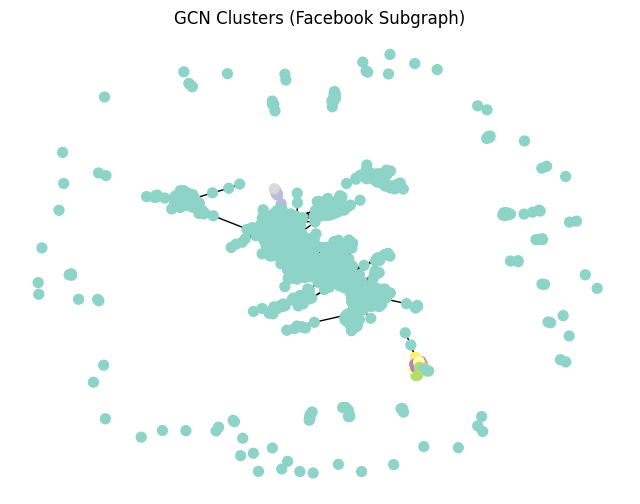

In [87]:
partition_dict = dict(zip(df_fb['Node'], df_fb['Cluster']))

visualize_communities(
    G_facebook_sub,      # the subgraph used above
    partition_dict,
    title="GCN Clusters (Facebook Subgraph)"
)

In [89]:
import os
def load_twitter_subset(file_path="twitter.tar.gz", ego_ids=None):
    """
    Loads a subset of ego networks from the Twitter tar.gz file.
    
    Args:
        file_path (str): Path to the twitter.tar.gz archive.
        ego_ids (list of int, optional): A list of ego network IDs you want to load.
                                         If None, the function loads all networks.
    
    Returns:
        subset_networks (dict): A dictionary where keys are ego IDs and values are
                                corresponding NetworkX graphs.
    """
    subset_networks = {}
    with tarfile.open(file_path, "r:gz") as tar:
        for member in tar.getmembers():
            # Process only edge files
            if member.name.endswith(".edges"):
                # Extract the file name without directory info (e.g., "3437.edges")
                base_name = os.path.basename(member.name)
                ego_id_str, _ = os.path.splitext(base_name)
                try:
                    ego_id = int(ego_id_str)
                except ValueError:
                    continue  # Skip files that don't match the pattern
                
                # If ego_ids list is provided, only load if ego_id is in that list
                if ego_ids is not None and ego_id not in ego_ids:
                    continue

                # Load the ego network for this ego_id
                f = tar.extractfile(member)
                G = nx.Graph()
                for line in f:
                    u, v = map(int, line.decode().strip().split())
                    G.add_edge(u, v)
                subset_networks[ego_id] = G
                
    return subset_networks

selected_ego_ids = [11681802, 31317273, 17135931, 51775432, 484991854, 15977848, 15589323, 21028234, 93998005, 14618160, 196926575, 83285096, 18846990, 36836787, 249831237, 19225156, 18069824, 10146102, 64931560, 18690700, 179138862, 75370828, 258447233, 25344777, 14134942, 15420650, 21420959, 18338485, 20561154, 26234692, 14827526, 174285878, 14630490, 21339164, 72339761, 428333, 790205, 103865085, 18191231, 120459837, 324201646, 20446839, 18630326, 6165372, 22879382, 234169190, 21077642]
twitter_networks = load_twitter_subset("twitter.tar.gz", ego_ids=selected_ego_ids)
print(twitter_networks)
# Print info about the loaded networks:
total = 0
for ego, G in twitter_networks.items():
    print(f"Ego network {ego}:")
    print(f"  Number of nodes: {G.number_of_nodes()}")
    total += G.number_of_nodes()
    print(f"  Number of edges: {G.number_of_edges()}")
print("total", total)

{11681802: <networkx.classes.graph.Graph object at 0x000001BB09A7C3D0>, 31317273: <networkx.classes.graph.Graph object at 0x000001BB09A7C8E0>, 17135931: <networkx.classes.graph.Graph object at 0x000001BA99F47850>, 51775432: <networkx.classes.graph.Graph object at 0x000001BB09A7C370>, 484991854: <networkx.classes.graph.Graph object at 0x000001BB09A7CFA0>, 15977848: <networkx.classes.graph.Graph object at 0x000001BB09A7C1F0>, 15589323: <networkx.classes.graph.Graph object at 0x000001BB09A7F400>, 21028234: <networkx.classes.graph.Graph object at 0x000001BB09A7F3D0>, 93998005: <networkx.classes.graph.Graph object at 0x000001BB09A7F430>, 14618160: <networkx.classes.graph.Graph object at 0x000001BB09A7F490>, 196926575: <networkx.classes.graph.Graph object at 0x000001BB09A7F4C0>, 83285096: <networkx.classes.graph.Graph object at 0x000001BB09A7F550>, 18846990: <networkx.classes.graph.Graph object at 0x000001BB09A7F4F0>, 36836787: <networkx.classes.graph.Graph object at 0x000001BB09A7F460>, 249

In [92]:
def load_node_features(file_path="facebook.tar.gz"):
    """
    Loads node feature vectors from .feat files in the tar.gz archive.
    
    Returns:
        features_dict (dict): A dictionary where each key is an ego node id (int)
                              and the value is a list of feature vectors (lists of ints)
                              for the nodes in that ego network.
    """
    features_dict = {}
    with tarfile.open(file_path, "r:gz") as tar:
        for member in tar.getmembers():
            if member.name.endswith(".feat"):
                base_name = os.path.basename(member.name)  # e.g., "3437.feat"
                ego_id_str, _ = os.path.splitext(base_name)
                try:
                    ego_id = int(ego_id_str)
                except ValueError:
                    print(f"Skipping file with unexpected name format: {member.name}")
                    continue
                f = tar.extractfile(member)
                lines = f.read().decode().splitlines()
                # Each line is a space-separated list of 0s and 1s
                features = [list(map(int, line.split())) for line in lines if line.strip()]
                features_dict[ego_id] = features
    return features_dict

def load_feature_names(file_path="facebook.tar.gz"):
    """
    Loads feature names from .featnames files in the tar.gz archive.
    
    Returns:
        featnames_dict (dict): A dictionary where each key is an ego node id (int)
                               and the value is a list of feature names (strings).
    """
    featnames_dict = {}
    with tarfile.open(file_path, "r:gz") as tar:
        for member in tar.getmembers():
            if member.name.endswith(".featnames"):
                base_name = os.path.basename(member.name)  # e.g., "3437.featnames"
                ego_id_str, _ = os.path.splitext(base_name)
                try:
                    ego_id = int(ego_id_str)
                except ValueError:
                    print(f"Skipping file with unexpected name format: {member.name}")
                    continue
                f = tar.extractfile(member)
                names = f.read().decode().splitlines()
                featnames_dict[ego_id] = names
    return featnames_dict


file_path = "facebook.tar.gz"
node_features = load_node_features(file_path)
feature_names = load_feature_names(file_path)

# For one ego network, say ego 3437:
ego_id = 3437
if ego_id in node_features and ego_id in feature_names:
    print(f"Feature names for ego {ego_id}:")
    print(feature_names[ego_id])
    print("\nA few node feature vectors:")
    for vec in node_features[ego_id][:10]:
        print(vec)
else:
    print("Feature data for this ego id is not available.")

Feature names for ego 3437:
['0 birthday;anonymized feature 1172', '1 birthday;anonymized feature 208', '2 birthday;anonymized feature 0', '3 birthday;anonymized feature 1', '4 birthday;anonymized feature 209', '5 birthday;anonymized feature 2', '6 birthday;anonymized feature 3', '7 birthday;anonymized feature 6', '8 education;concentration;id;anonymized feature 1173', '9 education;concentration;id;anonymized feature 13', '10 education;concentration;id;anonymized feature 384', '11 education;concentration;id;anonymized feature 386', '12 education;concentration;id;anonymized feature 14', '13 education;concentration;id;anonymized feature 1009', '14 education;concentration;id;anonymized feature 388', '15 education;concentration;id;anonymized feature 15', '16 education;concentration;id;anonymized feature 389', '17 education;concentration;id;anonymized feature 1174', '18 education;concentration;id;anonymized feature 338', '19 education;concentration;id;anonymized feature 392', '20 education;

# Theoretical Exercises 

In [93]:
import os
import tarfile
import networkx as nx

def load_graph(file_path="facebook.tar.gz"):
    """
    Loads the entire Facebook undirected graph from the .edges files in facebook.tar.gz.
    Returns a NetworkX Graph.
    """
    G = nx.Graph()
    with tarfile.open(file_path, "r:gz") as tar:
        for member in tar.getmembers():
            if member.name.endswith(".edges"):
                f = tar.extractfile(member)
                for line in f:
                    node1, node2 = map(int, line.decode().strip().split())
                    G.add_edge(node1, node2)
    return G


def load_node_features(file_path="facebook.tar.gz"):
    """
    Loads node feature vectors from .feat files in the tar.gz archive.

    Returns a dict: node_features[node_id] = [ [feat_row_1], [feat_row_2], ... ]
    for that node's ego network. In many .feat files, the first column is the node ID 
    and the remainder are the binary features. We'll unify them so that node_id -> single vector.
    """
    features_dict = {}
    with tarfile.open(file_path, "r:gz") as tar:
        for member in tar.getmembers():
            if member.name.endswith(".feat"):
                base_name = os.path.basename(member.name)  # e.g., "3437.feat"
                ego_id_str, _ = os.path.splitext(base_name)
                try:
                    ego_id = int(ego_id_str)
                except ValueError:
                    # Skip any unexpected format
                    continue
                f = tar.extractfile(member)
                lines = f.read().decode().splitlines()

                # Typically, each line: N+1 columns => first is node_id, rest are 0/1 features
                # We'll parse them into a dictionary: node_id -> feature_vector
                for line in lines:
                    arr = line.strip().split()
                    if not arr:
                        continue
                    node_id_ = int(arr[0])
                    # The rest are 0/1 features
                    feats = list(map(int, arr[1:]))

                    # We'll store just the last row we see for each node. 
                    # Typically, there's exactly 1 row per node in that ego net.
                    # If you prefer to store them all, you'd need a more complex merging strategy.
                    features_dict[node_id_] = feats

    return features_dict


def load_feature_names(file_path="facebook.tar.gz"):
    """
    Loads feature names from .featnames files in the tar.gz archive.
    Returns a dict: featnames[node_id] = [list of feature name strings].
    """
    featnames_dict = {}
    with tarfile.open(file_path, "r:gz") as tar:
        for member in tar.getmembers():
            if member.name.endswith(".featnames"):
                base_name = os.path.basename(member.name)  # e.g., "3437.featnames"
                ego_id_str, _ = os.path.splitext(base_name)
                try:
                    ego_id = int(ego_id_str)
                except ValueError:
                    continue
                f = tar.extractfile(member)
                names = f.read().decode().splitlines()
                featnames_dict[ego_id] = names
    return featnames_dict


In [94]:
import numpy as np

def build_feature_matrix(G, node_features_dict):
    """
    Creates a unified feature matrix for all nodes in G.
    
    :param G: NetworkX graph
    :param node_features_dict: dict { node_id : feature_list_of_0_1 }
    :return: (X, node_list)
        X is a NumPy array [num_nodes, feat_dim]
        node_list is the sorted list of node IDs 
                 (so X[i] corresponds to node_list[i])
    """
    node_list = sorted(G.nodes())
    # Find max feature dimension
    max_dim = 0
    for nid, feats in node_features_dict.items():
        max_dim = max(max_dim, len(feats))

    # Initialize X
    N = len(node_list)
    X = np.zeros((N, max_dim), dtype=np.float32)

    # Fill in the features
    nid_to_idx = {n: i for i, n in enumerate(node_list)}
    for nid, feats in node_features_dict.items():
        if nid in nid_to_idx:
            row_idx = nid_to_idx[nid]
            # If feats is shorter than max_dim, the remainder are zeros
            length = min(len(feats), max_dim)
            X[row_idx, :length] = feats[:length]

    return X, node_list


In [95]:
import torch
import torch.nn as nn
import torch.optim as optim
import scipy.sparse as sp

class SimpleGCN(nn.Module):
    def __init__(self, input_dim, embed_dim=32):
        """
        1-layer GCN: Z = ReLU( A @ X @ W )
        where A is adjacency (with self-loops & row normalization).
        """
        super().__init__()
        self.input_dim = input_dim
        self.embed_dim = embed_dim
        
        # Weight matrix W: [input_dim, embed_dim]
        self.W = nn.Parameter(torch.randn(input_dim, embed_dim) * 0.01)
        self.relu = nn.ReLU()
    
    def forward(self, A, X):
        """
        :param A: adjacency matrix (torch.FloatTensor) [N, N]
        :param X: node features (torch.FloatTensor) [N, input_dim]
        :return: Z [N, embed_dim]
        """
        # (A @ X) is [N, input_dim]
        out = A @ X @ self.W  # shape [N, embed_dim]
        out = self.relu(out)
        return out

class GCNLinkPredictor:
    """
    Wrapper for training the above SimpleGCN via link prediction (negative sampling).
    """
    def __init__(self, input_dim, embed_dim=32):
        self.model = SimpleGCN(input_dim, embed_dim)
    
    def train_neg_sampling(self, A_sp, X_np, edge_list, epochs=50, lr=0.01, neg_ratio=2):
        """
        :param A_sp: adjacency in scipy csr_matrix format (with self-loops + row-normal if desired)
        :param X_np: node features in numpy array [N, input_dim]
        :param edge_list: list of (u,v) for real edges (undirected => both directions)
        :param epochs, lr, neg_ratio, ...
        """
        # Convert to torch
        A_torch = torch.FloatTensor(A_sp.toarray())  # [N, N]
        X_torch = torch.FloatTensor(X_np)            # [N, input_dim]
        
        pos_edges = torch.LongTensor(edge_list)      # [E, 2]
        E = pos_edges.shape[0]
        N = A_torch.shape[0]
        
        optimizer = optim.Adam(self.model.parameters(), lr=lr)
        bce = nn.BCEWithLogitsLoss()

        for epoch in range(epochs):
            # 1) Negative edges
            neg_count = neg_ratio * E
            neg_edges = []
            tries = 0
            while len(neg_edges) < neg_count and tries < neg_count*5:
                u = np.random.randint(0, N)
                v = np.random.randint(0, N)
                if u != v:
                    neg_edges.append((u, v))
                tries += 1
            neg_edges = torch.LongTensor(neg_edges)
            
            # 2) Forward => embeddings
            Z = self.model(A_torch, X_torch) # [N, embed_dim]
            
            # 3) Dot-product for pos and neg edges
            pos_u = Z[pos_edges[:,0]]
            pos_v = Z[pos_edges[:,1]]
            pos_scores = (pos_u * pos_v).sum(dim=1)  # [E]
            
            neg_u = Z[neg_edges[:,0]]
            neg_v = Z[neg_edges[:,1]]
            neg_scores = (neg_u * neg_v).sum(dim=1)  # [neg_count]
            
            # 4) Labels
            pos_label = torch.ones_like(pos_scores)
            neg_label = torch.zeros_like(neg_scores)
            
            all_scores = torch.cat([pos_scores, neg_scores], dim=0)
            all_labels = torch.cat([pos_label, neg_label], dim=0)
            
            loss = bce(all_scores, all_labels)
            
            # 5) Backprop
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            if (epoch+1) % 10 == 0:
                print(f"Epoch {epoch+1}/{epochs} - Loss: {loss.item():.5f}")
    
    def get_embeddings(self, A_sp, X_np):
        """
        Return the node embeddings from the trained GCN.
        """
        A_torch = torch.FloatTensor(A_sp.toarray()) 
        X_torch = torch.FloatTensor(X_np)
        with torch.no_grad():
            Z = self.model(A_torch, X_torch)
        return Z.numpy()  # shape [N, embed_dim]


In [96]:
import matplotlib.pyplot as plt
from collections import defaultdict
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

def visualize_communities(G, partition, title="Communities Visualization"):
    """
    Color-codes each node by its assigned community in 'partition'.
    """
    pos = nx.spring_layout(G, seed=42)
    communities = [partition[node] for node in G.nodes()]
    
    plt.figure(figsize=(8, 6))
    nx.draw_networkx(
        G, 
        pos=pos, 
        node_color=communities,
        cmap=plt.cm.Set3,  # or any colormap
        with_labels=False,
        node_size=50
    )
    plt.title(title)
    plt.axis('off')
    plt.show()

def sample_graph(G, max_nodes=1000, seed=42):
    """
    Return a random induced subgraph of G with up to max_nodes nodes.
    """
    import random
    random.seed(seed)
    if len(G) <= max_nodes:
        return G.copy()
    nodes_sampled = random.sample(G.nodes(), max_nodes)
    return G.subgraph(nodes_sampled).copy()

def row_normalize_sparse(A):
    """
    Row-normalize a scipy CSR adjacency matrix A.
    """
    # sum of each row
    row_sum = np.array(A.sum(axis=1)).flatten()
    # avoid division by zero
    row_sum[row_sum == 0] = 1e-10
    inv_sum = 1.0 / row_sum
    D_inv = sp.diags(inv_sum)
    A_norm = D_inv.dot(A)
    return A_norm

def run_facebook_gcn_embedding(
    file_path="facebook.tar.gz",
    embed_dim=32,
    epochs=50,
    lr=0.01,
    k=5,
    max_nodes_plot=500
):
    """
    1) Load Facebook graph + node features
    2) Build adjacency with self-loops + row-normalization
    3) Train GCN with negative sampling
    4) K-Means => silhouette
    5) Visualize a subgraph
    """
    # --- Load graph
    G = load_graph(file_path)
    print(f"Original Graph: {G.number_of_nodes()} nodes, {G.number_of_edges()} edges.")

    # --- Load node features
    node_features_dict = load_node_features(file_path)
    # (feature_names_dict = load_feature_names(file_path)) # if you want

    # --- Build feature matrix
    X_np, node_list = build_feature_matrix(G, node_features_dict)
    print(f"Feature matrix: shape={X_np.shape}")

    # --- Build adjacency (with self-loops)
    import scipy.sparse as sp
    node_index = {n: i for i, n in enumerate(node_list)}
    
    # create adjacency
    row = []
    col = []
    for u, v in G.edges():
        if u in node_index and v in node_index:
            row.append(node_index[u])
            col.append(node_index[v])
            row.append(node_index[v])
            col.append(node_index[u])  # undirected => both ways

    N = len(node_list)
    data = np.ones(len(row), dtype=np.float32)
    A_sp = sp.csr_matrix((data, (row, col)), shape=(N, N))
    
    # add self-loops
    A_sp.setdiag(1.0)
    A_sp.eliminate_zeros()

    # optional row-normalize
    A_sp = row_normalize_sparse(A_sp)

    # --- Prepare edges for negative sampling
    edge_list = []
    for u, v in G.edges():
        # only if both in node_index
        if u in node_index and v in node_index:
            edge_list.append((node_index[u], node_index[v]))
            # (v,u) is accounted for if we appended both directions above
            # but for the link prediction, we typically add (u,v) + (v,u).
            # We'll do that in the GCNLinkPredictor for safety, or do it here:
            edge_list.append((node_index[v], node_index[u]))

    # --- Train GCN
    input_dim = X_np.shape[1]
    predictor = GCNLinkPredictor(input_dim, embed_dim=embed_dim)
    predictor.train_neg_sampling(A_sp, X_np, edge_list, epochs=epochs, lr=lr, neg_ratio=2)

    # --- Get embeddings
    Z = predictor.get_embeddings(A_sp, X_np)
    print(f"Embeddings shape={Z.shape}")  # [N, embed_dim]

    # --- K-Means
    kmeans = KMeans(n_clusters=k, random_state=42)
    labels = kmeans.fit_predict(Z)
    sil = silhouette_score(Z, labels) if k>1 else 0.0
    print(f"Silhouette score (k={k}) = {sil:.4f}")

    # Build partition dict: node -> cluster
    partition = {}
    for i, nid in enumerate(node_list):
        partition[nid] = labels[i]

    # --- Visualization on a subgraph
    # pick a random subgraph or so
    G_small = sample_graph(G, max_nodes_plot)
    # build partition for the subgraph's nodes
    part_small = {n: partition[n] for n in G_small.nodes() if n in partition}
    visualize_communities(G_small, part_small, title="GCN Clusters (Facebook)")

    return partition, sil, Z, node_list


Original Graph: 3959 nodes, 84243 edges.
Feature matrix: shape=(3959, 576)
Epoch 10/50 - Loss: 0.61549
Epoch 20/50 - Loss: 0.59856
Epoch 30/50 - Loss: 0.58531
Epoch 40/50 - Loss: 0.57975
Epoch 50/50 - Loss: 0.57765
Embeddings shape=(3959, 32)
Silhouette score (k=10) = 0.7548


C:\Users\Joao Pedro\AppData\Local\Temp\ipykernel_18300\3819479087.py:34: DeprecationWarning: Sampling from a set deprecated
since Python 3.9 and will be removed in a subsequent version.
  nodes_sampled = random.sample(G.nodes(), max_nodes)


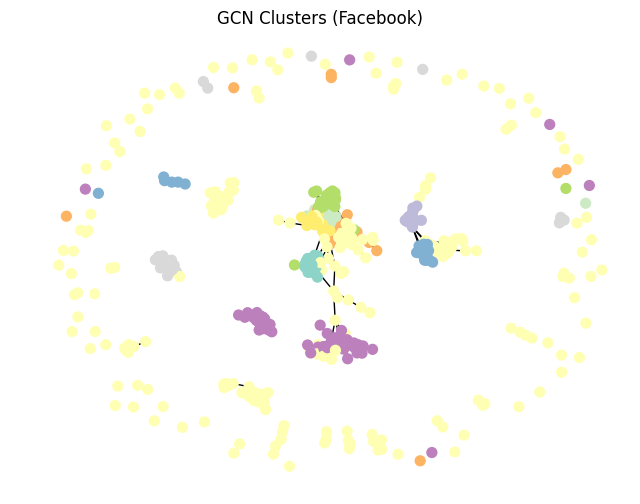

Final silhouette: 0.7548


In [98]:
# Just call the pipeline:
partition, sil, Z, node_list = run_facebook_gcn_embedding(
    file_path="facebook.tar.gz",
    embed_dim=32,
    epochs=50,
    lr=0.01,
    k=10,
    max_nodes_plot=500
)

print(f"Final silhouette: {sil:.4f}")


## Exercise 1: Properties of the Normalised Laplacians

In spectral graph theory, in addition to the unnormalised Laplacian $L$, two commonly used normalised Laplacians are:

1. **Symmetric Normalised Laplacian**

   $$
   L_{\text{sym}} = D^{-\frac{1}{2}} L \, D^{-\frac{1}{2}} \;=\; I - D^{-\frac{1}{2}}\,A\,D^{-\frac{1}{2}}
   $$

2. **Random Walk Laplacian**

   $$
   L_{\text{rw}} = D^{-1} L \;=\; I - D^{-1} A
   $$

Below are the key properties of each.

---

### 1. Symmetric Normalised Laplacian

#### Symmetry

$$
L_{\text{sym}} = L_{\text{sym}}^T
$$

Hence, $L_{\text{sym}}$ is symmetric. As a result, all its eigenvalues are real, and its eigenvectors can be chosen to be orthonormal.


#### Positive Semi-Definiteness

For any vector $x$,

$$
x^T L_{\text{sym}} \, x \;\ge\; 0,
$$

which implies $L_{\text{sym}}$ is positive semi-definite. Consequently, all eigenvalues $\lambda$ satisfy

$$
\lambda \;\ge\; 0.
$$


#### Spectrum Bounds

All eigenvalues of $L_{\text{sym}}$ lie in the interval

$$
[\,0,\;2\,].
$$


#### Multiplicity of the Zero Eigenvalue

The number of connected components in the graph equals the multiplicity of the eigenvalue 0.

If a graph has $k$ disconnected components, then $0$ will be an eigenvalue of $L_{\text{sym}}$ with multiplicity $k$.


#### Usage in Spectral Clustering

The eigenvectors corresponding to the smallest eigenvalues (excluding the trivial zero eigenvalue if the graph is connected) are often used to embed the nodes into a lower-dimensional space for clustering.

---

### 2. Random Walk Laplacian

#### Non-Symmetry

In general,

$$
L_{\text{rw}} \;=\; D^{-1} L
$$

is not necessarily symmetric. However, \($L_{\text{rw}}$\) is similar to \($L_{\text{sym}}$\) via

$$
L_{\text{rw}}
\;=\;
D^{-\tfrac{1}{2}}\;L_{\text{sym}}\;D^{\tfrac{1}{2}},
$$

which ensures that $L_{\text{rw}}$ and $L_{\text{sym}}$ share the same eigenvalues.

#### Row-Stochastic Relationship

Observe that

$$
I \;-\; L_{\text{rw}}
\;=\;
D^{-1} A,
$$

which is a row-stochastic matrix (each row sums to 1). It represents the transition probabilities of a random walk on the graph.

#### Spectrum Bounds

Like \($L_{\text{sym}}$\), all eigenvalues of $L_{\text{rw}}$ lie within

$$
[\,0,\;2\,].
$$

Again, the eigenvalue $0$ appears with multiplicity equal to the number of connected components.

#### Interpretation of the Zero Eigenvalue

For $L_{\text{rw}}$, the eigenvector corresponding to the eigenvalue $0$ is (or is proportional to) the constant vector. In random-walk terms, it can be interpreted as a stationary distribution on a connected component.

#### Application in Random Walks and Diffusion

Since

$$
L_{\text{rw}} = I - D^{-1} A,
$$

it arises naturally in analyzing diffusion processes and random walks on graphs, emphasizing how probability transitions evolve between nodes.

---

### NB:

Both the symmetric normalised Laplacian and the random walk Laplacian offer advantages over the unnormalised Laplacian:

- **Degree Normalisation**:  
  They mitigate the influence of varying node degrees, making them particularly useful for graphs with heterogeneous connectivity.

- **Reflecting Graph Connectivity**:  
  The multiplicity of the zero eigenvalue indicates the number of disconnected components, a key feature in both spectral clustering and community detection.

- **Spectral Properties**:  
  Their eigenvalues lie in a known interval (typically \[0,2\] ), and the structure of the eigenvectors provides insights into the graph's community structure and the dynamics of random walks.

---

## Exercise 2: Compare the Different Clusterings Using Different Laplacian Eigenmaps

In the general spectral clustering approach, we choose an appropriate Laplacian (e.g., unnormalised $L$, symmetric normalised $L_{\text{sym}}$, or random walk $L_{\text{rw}}$) and then use the eigenvectors corresponding to the $k$ smallest eigenvalues (beyond the trivial zero eigenvalue if the graph is connected). By embedding the nodes in a $k$-dimensional space via these eigenvectors and then applying $k$-means, we obtain a partition of the graph into $k$ clusters.

When comparing different clusterings (for instance, using $L$ vs. $L_{\text{sym}}$ vs. $L_{\text{rw}}$), one can consider:

1. **Modularity**:  
   - Evaluate how well each clustering partitions the graph into densely connected communities. Higher modularity values indicate that there are more intra-cluster edges and fewer inter-cluster edges relative to a random baseline.

2. **Silhouette Score**:  
   - Compute the silhouette coefficient of the embedded points (rows of the eigenvector matrix $U$) after $k$-means. This measures how similar a node is to others within its cluster compared to nodes in other clusters. A higher silhouette (close to $1$) implies better separation.

3. **Visual Inspection**:  
   - For smaller graphs or 2D/3D embeddings (e.g., taking 2–3 eigenvectors), one can plot the node embeddings and color them by their assigned cluster to see how well-separated they appear.

4. **Community Sizes**:  
   - Check whether different Laplacians yield unbalanced clusters (one large cluster vs. many small ones) or more evenly distributed clusters.

---

## Exercise 3: Formalizing the Approximation of the **RatioCut** for Arbitrary $ k $

For an arbitrary number of clusters $ k $, the RatioCut minimization problem

$$
\min_{V_1, \dots, V_k}
\;\;
\text{RatioCut}(V_1, \dots, V_k)
\quad
\text{where}
\quad
\text{RatioCut}(V_1, \dots, V_k)
\;=\;
\frac{1}{2}
\sum_{i=1}^k
\frac{\left|\{(u,v)\in E : u\in V_i,\;v\in\overline{V_i}\}\right|}
{\lvert V_i\rvert},
$$

is **NP-hard** when the subsets $\{V_1,\dots,V_k\}$ must be discrete partitions of $V$. The standard **spectral relaxation** for approximating this problem is:

1. **Compute the $k$ Smallest Eigenvectors**  
   - Let $L$ be the (unnormalised) Laplacian of the graph.
   - Find the $k$ eigenvectors $ \mathbf{u}_1, \dots, \mathbf{u}_k $ corresponding to the $k$ smallest eigenvalues of $L$.  
     - If the graph is connected, the smallest eigenvalue is $0$, and its eigenvector is the all-ones vector (the trivial cluster). We typically use the next $k-1$ eigenvectors beyond this trivial one, so we end up with $k$ non-trivial eigenvectors in total.

2. **Build the Embedding Matrix**  
   - Form a matrix $U \;\in\; \mathbb{R}^{|V|\times k}$ whose $k$ columns are the eigenvectors from Step 1.  
   - Each row $U[v]$ is then the $k$-dimensional embedding of node $v$.

3. **Cluster the Embedded Points**  
   - Treat each node $v$ as a point in $\mathbb{R}^k$ given by $U[v]$.
   - Apply a standard clustering algorithm (e.g., $k$-means) on these row vectors to produce $k$ clusters.

4. **Obtain an Approximate RatioCut**  
   - The resulting partition of nodes from $k$-means corresponds to an approximate minimizer of the RatioCut objective.  
   - While this approach is only a relaxation of the original NP-hard problem, in practice it often yields high-quality partitions.

**Key Intuition**  
- By using the eigenvectors associated with the smallest eigenvalues of $L$, we find a subspace capturing “smooth” cuts in the graph.
- Embedding nodes into this low-dimensional space preserves structural information relevant to minimizing inter-cluster edges while avoiding excessively small clusters—i.e., approximating the RatioCut objective.

This general **$k$-way spectral clustering** procedure extends naturally from the simpler $k=2$ case (the Fiedler vector) to partitioning into multiple clusters.

---

## Exercise 4: Comparing node2vec Embeddings to Laplacian Eigenmaps

Both Laplacian eigenmaps and node2vec aim to learn low-dimensional representations for nodes in a graph, but they approach the task from very different angles.


### Objective and Formulation

- **Laplacian Eigenmaps:**  
  Laplacian eigenmaps are based on a spectral formulation. The method solves a relaxed optimization problem that minimizes
  $$
  \sum_{(u,v)\in E} \| \mathbf{z}_u - \mathbf{z}_v \|_2^2
  $$
  subject to constraints on the embeddings. This objective preserves local neighborhood relationships by ensuring that connected nodes have similar representations.

- **node2vec:**  
  In contrast, node2vec uses a biased random walk strategy to sample neighborhoods and then leverages the Skip-gram model to learn embeddings. Its objective is to maximize the likelihood of preserving network neighborhoods:
  $$
  \max_f \sum_{u \in V} \log \Pr(\mathcal{N}(u)|f(u))
  $$
  where $\mathcal{N}(u)$ is the set of nodes sampled from biased random walks starting at node $u$. This formulation is inspired by natural language processing techniques and is optimized via stochastic gradient descent.


### Computational Considerations

- **Laplacian Eigenmaps:**  
  Computing Laplacian eigenmaps requires the eigen-decomposition of the graph Laplacian, which becomes computationally expensive for large networks. The method is linear in nature and relies on standard linear algebra routines.

- **node2vec:**  
  node2vec, on the other hand, circumvents the need for eigen-decomposition by simulating biased random walks and using efficient optimization (e.g., negative sampling with SGD). This makes node2vec more scalable to large graphs.


### Flexibility and Expressiveness

- **Laplacian Eigenmaps:**  
  The approach inherently focuses on preserving local geometries in the graph. While this is effective for capturing nearby relationships (often useful in spectral clustering), it is relatively rigid and does not easily allow for tuning to capture more diverse notions of similarity.

- **node2vec:**  
  node2vec introduces flexibility through parameters (commonly denoted as $p$ and $q$) that control the bias of the random walks. These parameters allow the method to interpolate between:
  
  - **BFS-like behavior:** Favoring local exploration to capture structural equivalence.
  - **DFS-like behavior:** Encouraging longer-range walks that capture community (homophilic) structures.
  
  This flexibility lets node2vec capture a richer set of patterns in the graph beyond what is possible with a fixed spectral method.


### Quality and Interpretability of Embeddings

- **Laplacian Eigenmaps:**  
  The embeddings are directly tied to the eigenstructure of the Laplacian. For example, the Fiedler vector (the eigenvector corresponding to the second-smallest eigenvalue) is well known for providing a good bi-partition of the graph. However, the linear nature of this method may limit its ability to capture complex, non-linear relationships in the data.

- **node2vec:**  
  The embeddings learned by node2vec capture higher-order proximities by considering a broader, probabilistic view of node neighborhoods. This often results in representations that are more effective for downstream tasks such as node classification and link prediction, although they might be less directly interpretable in terms of classical spectral properties.


### Summary

- **Laplacian Eigenmaps** offer a mathematically elegant and interpretable solution grounded in spectral graph theory, best suited for preserving local geometric structure. Their reliance on eigen-decomposition can, however, limit scalability and flexibility.

- **node2vec** leverages random walks and a Skip-gram based objective to learn embeddings that are more flexible and scalable. Its parameterized random walk strategy allows one to tune the exploration to capture both local (structural equivalence) and global (community structure) relationships.

Ultimately, while Laplacian eigenmaps provide a strong baseline rooted in linear algebra, node2vec’s probabilistic and flexible framework often leads to superior performance in real-world tasks by capturing richer and more nuanced patterns in network data.
